# **Hack IMDb Rating**

## **Introduction**

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## **Research Questions**

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - The influence of release timing on ratings
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   - Movie runtime and link with average rating correlation
   - Impact of the movie era
   - Impact of number of votes in IMDb rating

2. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres
   - Exploration of propaganda films and their ratings impact
   

3. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

4. *What impact do actors have on a film's rating?*
   - The role of actor having an oscar or an oscar nomination on the IMDb rating

5. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction
   - Implementing sentiment analysis of movie reviews and comments

## **Additional Dataset**

To enrich our analysis, we will add the IMDb ratings dataset.

By addressing these questions with  analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.


In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.subplots as ps
import json
import scipy.stats as stats
from wordcloud import WordCloud

# import helper.py
from scripts.helper import *
from scripts.genre_label_helpers import *
from scripts.regression_loader_helpers import *

# plot settings
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("Set2")
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

---

# **Data Pipeline**


## **Dataset Overview**

### **CMU Movie Summary Corpus**

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### **IMDb Rating Dataset**

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### **Events Dataset**

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

### **Oscar Dataset**

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


#### **1. Loading CMU Data**

We define the `cmu_data_folder` constant to store the path to the CMU Movie Summary Corpus data folder. We then load the data from the different files into pandas dataframes.

In [2]:
cmu_data_folder = 'data/CMU_DATA/'

We define the `movie_metadata_df` dataframe, which contains information about the movies, such as title, box office revenue, movie runtime, genre, and release year.

In [3]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv(cmu_data_folder + 'movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year
movie_metadata_df['movie_release_year'] = \
        movie_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the movie_metadata_df:", movie_metadata_df.shape)
movie_metadata_df.sample(5)

Size of the movie_metadata_df: (81741, 10)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
18606,2994014,/m/08jc0x,The NeverEnding Story III,1994,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",1994.0
14371,21412707,/m/05f7k9x,Amexicano,2007,NaN,84.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0219x_"": ""Indie""}",2007.0
77809,4277184,/m/0btqtd,The Naked Truth,1992,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/05p553"": ""Comedy fi...",1992.0
21607,30882696,/m/0gg4kzf,Stolen Heaven,1931-02-21,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",1931.0
62548,3387352,/m/03jkk6q,"Stop Snitchin', Stop Lyin'",2006,NaN,60.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/026v1nw"": ""Hip hop movies"", ""/m/0jtdp"": ""...",2006.0


We define the `plot_summaries_df` dataframe, which contains summaries of movie plots.

In [4]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv(cmu_data_folder + 'plot_summaries.txt', sep='\t', 
                                header=None, 
                                names=['wiki_movie_id', 'plot_summary'])

print("Size of the plot_summaries_df:", plot_summaries_df.shape)
plot_summaries_df.sample(5)

Size of the plot_summaries_df: (42303, 2)


,wiki_movie_id,plot_summary
20643,16314437,"A widower locks up his two children, afraid th..."
9615,20703482,"Living the Dream is a story about two friends,..."
23730,30170055,Events depicted in the movie unfold in the lat...
32116,15283053,A detective searching for the cause of a young...
24479,13272614,In a nightly escape from his day job as a mech...


We define the `character_metadata_df` dataframe, which contains metadata information about movie characters and actors.

In [5]:
#read text file and add headers
character_metadata_df = pd.read_csv(cmu_data_folder + 'character.metadata.tsv', sep='\t', 
                                    header=None, 
                                    names=['wiki_movie_id',
                                    'freebase_movie_id',
                                    'movie_release_date',
                                    'character_name',
                                    'actor_date_of_birth',
                                    'actor_gender',
                                    'actor_height',
                                    'actor_ethnicity',
                                    'actor_name',
                                    'actor_age_at_movie_release',
                                    'freebase_character_actor_map_id',
                                    'freebase_character_id',
                                    'freebase_actor_id'])

# add movie_release_year
character_metadata_df['movie_release_year'] = \
    character_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the character_metadata_df:", character_metadata_df.shape)
character_metadata_df.sample(5)

Size of the character_metadata_df: (450669, 14)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year
81882,424829,/m/026xqc,1995-12-09,NaN,1942-11-07,M,NaN,NaN,Minori Terada,53.0,/m/0cg84v3,NaN,/m/0jw59g,1995.0
47033,12626400,/m/02wypx0,1966-01,NaN,1920,NaN,NaN,NaN,Pauline Jameson,NaN,/m/0gc90k0,NaN,/m/0gbylb3,1966.0
432617,17014422,/m/0415m3q,1976-01,David Lee / Tiger,1950-06-05,M,NaN,NaN,Bruce Li,NaN,/m/04hv77d,/m/0n4y041,/m/052mj4,1976.0
349190,20105797,/m/04ycsw4,1927-11-01,NaN,1887-01-29,M,NaN,NaN,Kokuten Kodo,NaN,/m/0j_tj65,NaN,/m/0k2w0d,1927.0
93304,740824,/m/037c_d,1995-02-10,Herod,1930-01-30,M,1.88,/m/07hwkr,Gene Hackman,65.0,/m/0k67b3,/m/0h6dxql,/m/039bp,1995.0


#### **2. Loading IMDB Data**

We define the `imdb_data_folder` constant to store the path to the IMDB rating dataset folder. We then load the data from the different files into pandas dataframes.

In [6]:
imdb_data_folder = 'data/IMDB_DATA/'

We define the `imdb_ratings_df` dataframe, which contains IMDb rating data. We construct this dataframe by merging the `rating_id_df`, which contains the ratings, and the `name_id_df`, which contains additional information about the movies (name, type, ...).

In [7]:
#load IMDB reviews
rating_id_df = pd.read_csv(imdb_data_folder + 'rating_id.tsv', sep='\t')
name_id_df = pd.read_csv(imdb_data_folder + 'name_id.tsv', sep='\t', 
                         usecols=['tconst', 'titleType', 'movie_name', 'startYear'])

# define '\N' as NaN
name_id_df = name_id_df.replace('\\N', np.nan)

# change startYear to float
name_id_df['startYear'] = name_id_df['startYear'].astype(float)

# merge rating_id_df and name_id_df
imdb_rating_df = pd.merge(rating_id_df, name_id_df, on='tconst', how='inner')

print("Size of the imdb_rating_df:", imdb_rating_df.shape)
imdb_rating_df.sample(5)

Size of the imdb_rating_df: (1368573, 6)


,tconst,averageRating,numVotes,titleType,movie_name,startYear
1045448,tt3588676,6.8,8,tvEpisode,Gone,2014.0
209151,tt0368091,6.8,16,short,La nuit de l'invasion des nains de jardins ven...,1997.0
162928,tt0267845,4.0,101,movie,Prem Shakti,1994.0
1268716,tt7423476,7.5,154,tvEpisode,Maja,2020.0
696348,tt14742814,6.5,63,movie,Mahin,2020.0


#### **3. Loading Events Data**

We define the `generated_data_folder` constant to store the path to the generated data folder. We then load the events into a pandas dataframe.

In [8]:
generated_data_folder = "data/GENERATED_DATA/"

We define the `events_df` dataframe, which contains the most significant events from 1820 to 2014.

In [9]:
#loading the events dataset
events_df = pd.read_csv(generated_data_folder + 'events.csv')

print("Size of the events_df:", events_df.shape)
events_df.sample(5)

Size of the events_df: (1902, 5)


,Year,Event Name,Event Description,Event Location,Event Category
1,1820,Antarctic Discovery,The British explorer James Weddell discovers t...,GBR,Science and health advancement
1222,1943,Tehran Conference,The Tehran Conference was a strategy meeting t...,IR,Political Events
622,1882,Trial and Execution of Charles Guiteau,"Charles Guiteau, the assassin of President Jam...",US,Political Events
445,1864,First Geneva Convention,This was significant in that it led to the cre...,CH,Political Events
1576,1980,Iran-Iraq War Begins,"The Iran-Iraq War begins, marking one of the l...",IR,Military Conflicts


#### **4. Loading Oscars Data**

We define the `oscars_data_folder` constant to store the path to the Oscars dataset folder. We then load the oscars data into a pandas dataframe.

In [10]:
oscars_data_folder = "data/OSCAR_DATASET/"

We define the `oscar_nominees_df` dataframe, which contains the winners and nominees of the Oscars from 1927 to 2016.

In [11]:
# read the oscar dataset
oscar_nominees_df = pd.read_csv(oscars_data_folder + 'the_oscar_award.csv')
# drop the ceremonies after 2016
oscar_nominees_df = oscar_nominees_df[oscar_nominees_df['year_ceremony'] < 2017]
# add a column for the number of nominations per category
oscar_nominees_df['nomination_count'] = \
    oscar_nominees_df.groupby(['year_ceremony', 'category'])['name'].transform('count')
# add a column for the number of wins per category
oscar_nominees_df['win_count'] = \
    oscar_nominees_df.groupby(['year_ceremony', 'category'])['winner'].transform('sum')

print("Size of the oscar_nominees_df:", oscar_nominees_df.shape)
oscar_nominees_df.sample(5)

Size of the oscar_nominees_df: (9889, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
5251,1974,1975,47,MUSIC (Original Dramatic Score),Jerry Goldsmith,Chinatown,False,5,1
860,1939,1940,12,MUSIC (Scoring),Dimitri Tiomkin,Mr. Smith Goes to Washington,False,13,1
5778,1979,1980,52,FILM EDITING,"Robert L. Wolfe, C. Timothy O'Meara",The Rose,False,5,1
7162,1992,1993,65,FOREIGN LANGUAGE FILM,Uruguay,A Place in the World,False,5,1
774,1938,1939,11,SPECIAL AWARD,Oliver Marsh and Allen Davey for the color ci...,NaN,True,6,6


We define the `oscar_winners_df` dataframe, which contains the winners of the Oscars from 1927 to 2016.

In [12]:
# filter the oscar dataset to only include winners
oscar_winners_df = oscar_nominees_df[oscar_nominees_df['winner'] == True]
oscar_winners_df = oscar_winners_df.drop(columns=['winner'])

print("Size of the oscar_winners_df:", oscar_winners_df.shape)
oscar_winners_df.sample(5)

Size of the oscar_winners_df: (2244, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
3243,1956,1957,29,SPECIAL EFFECTS,John Fulton,The Ten Commandments,2,1
147,1930,1931,4,SOUND RECORDING,Paramount Publix Studio Sound Department,NaN,4,1
2131,1947,1948,20,MUSIC (Song),Music by Allie Wrubel; Lyrics by Ray Gilbert,Song of the South,5,1
5234,1974,1975,47,DOCUMENTARY (Feature),"Peter Davis and Bert Schneider, Producers",Hearts and Minds,5,1
4207,1965,1966,38,ACTOR IN A SUPPORTING ROLE,Martin Balsam,A Thousand Clowns,5,1


In [13]:
# get the unique categories of the award
oscar_award_categories_df = pd.DataFrame(oscar_nominees_df['category'].unique())
oscar_award_categories_df.columns = ['category']
oscar_award_categories_df.sort_values(by=['category'], inplace=True, ignore_index=True)
oscar_award_categories_df.head()

,category
0,ACTOR
1,ACTOR IN A LEADING ROLE
2,ACTOR IN A SUPPORTING ROLE
3,ACTRESS
4,ACTRESS IN A LEADING ROLE


We define the `actor_nominees_df` dataframe, wich contains the actors who were nominated for the Oscars from 1927 to 2016.

In [14]:
# identify the categories that are related to actors
actor_reward_names = ['ACTOR', 
                      'ACTRESS', 
                      'ACTOR IN A LEADING ROLE', 
                      'ACTRESS IN A LEADING ROLE', 
                      'ACTOR IN A SUPPORTING ROLE', 
                      'ACTRESS IN A SUPPORTING ROLE']

actor_nominees_df = \
    oscar_nominees_df[oscar_nominees_df['category'].isin(actor_reward_names)]

print("Size of the actor_nominees_df:", actor_nominees_df.shape)
actor_nominees_df.sample(5)

Size of the actor_nominees_df: (1668, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
6370,1985,1986,58,ACTOR IN A SUPPORTING ROLE,Eric Roberts,Runaway Train,False,5,1
6486,1986,1987,59,ACTRESS IN A SUPPORTING ROLE,Mary Elizabeth Mastrantonio,The Color of Money,False,5,1
4669,1969,1970,42,ACTOR,Dustin Hoffman,Midnight Cowboy,False,5,1
5194,1974,1975,47,ACTOR,Jack Nicholson,Chinatown,False,5,1
5947,1981,1982,54,ACTRESS IN A LEADING ROLE,Meryl Streep,The French Lieutenant's Woman,False,5,1


We define the `actor_winning_df` dataframe, wich contains the actors who won the Oscars from 1927 to 2016.

In [15]:
# filter to only include winners
actor_winning_df = actor_nominees_df[actor_nominees_df['winner'] == True]
actor_winning_df = actor_winning_df.drop(columns=['winner'])

print("Size of the actor_winning_df:", actor_winning_df.shape)
actor_winning_df.sample(5)

Size of the actor_winning_df: (338, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
4570,1968,1969,41,ACTRESS,Katharine Hepburn,The Lion in Winter,5,2
4782,1970,1971,43,ACTOR IN A SUPPORTING ROLE,John Mills,Ryan's Daughter,5,1
2516,1951,1952,24,ACTOR IN A SUPPORTING ROLE,Karl Malden,A Streetcar Named Desire,5,1
1826,1945,1946,18,ACTRESS IN A SUPPORTING ROLE,Anne Revere,National Velvet,5,1
3719,1961,1962,34,ACTOR IN A SUPPORTING ROLE,George Chakiris,West Side Story,5,1


We define the `best_movie_nominees_df` dataframe, wich contains the movies that were nominated for the Oscars from 1927 to 2016.

In [16]:
# identify the categories that are related to movies
best_movie_reward_names = ['OUTSTANDING PICTURE',
                           'OUTSTANDING PRODUCTION',
                           'OUTSTANDING MOTION PICTURE',
                           'BEST MOTION PICTURE',
                           'BEST PICTURE']

best_movie_nominees_df = \
    oscar_nominees_df[oscar_nominees_df['category'].isin(best_movie_reward_names)]

print("Size of the best_movie_nominees_df:", best_movie_nominees_df.shape)
best_movie_nominees_df.sample(5)

Size of the best_movie_nominees_df: (528, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
9590,2013,2014,86,BEST PICTURE,"Alfonso Cuarón and David Heyman, Producers",Gravity,False,9,1
9714,2014,2015,87,BEST PICTURE,"Alejandro G. Iñárritu, John Lesher and James W...",Birdman or (The Unexpected Virtue of Ignorance),True,8,1
8531,2004,2005,77,BEST PICTURE,"Taylor Hackford, Stuart Benjamin and Howard Ba...",Ray,False,5,1
4958,1971,1972,44,BEST PICTURE,"Stephen J. Friedman, Producer",The Last Picture Show,False,5,1
66,1928,1929,2,OUTSTANDING PICTURE,Paramount Famous Lasky,The Patriot,False,5,1


We define the `best_movie_winners_df` dataframe, wich contains the movies that won the Oscars from 1927 to 2016.

In [17]:
# filter to only include winners
movie_winning_df = best_movie_nominees_df[best_movie_nominees_df['winner'] == True]
movie_winning_df = movie_winning_df.drop(columns=['winner'])

print("Size of the movie_winning_df:", movie_winning_df.shape)
movie_winning_df.sample(5)

Size of the movie_winning_df: (88, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
7969,1999,2000,72,BEST PICTURE,"Bruce Cohen and Dan Jinks, Producers",American Beauty,5,1
3680,1960,1961,33,BEST MOTION PICTURE,"Billy Wilder, Producer",The Apartment,5,1
6436,1985,1986,58,BEST PICTURE,"Sydney Pollack, Producer",Out of Africa,5,1
3559,1959,1960,32,BEST MOTION PICTURE,"Sam Zimbalist, Producer",Ben-Hur,5,1
4049,1963,1964,36,BEST PICTURE,"Tony Richardson, Producer",Tom Jones,5,1


#### **5. Merging The Movie Metadata With The IMDb Ratings**

We define the `movie_metadata_ratings_df` dataframe, which contains the movie metadata and the IMDb ratings. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `imdb_ratings_df` dataframe.

In [18]:
#merging the movie metadata with the rating data on movie name and release year
movie_metadata_rating_df = pd.merge(movie_metadata_df, 
                                    imdb_rating_df, 
                                    how='inner',
                                    left_on=['movie_name', 'movie_release_year'], 
                                    right_on=['movie_name', 'startYear'])

#drop startYear column
movie_metadata_rating_df = movie_metadata_rating_df.drop(columns=['startYear'])

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)
movie_metadata_rating_df.sample(5)

Size of the movie_metadata_rating_df: (51108, 14)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType
23660,3795154,/m/0b0d6m,Illusive Tracks,2003-12-25,NaN,100.0,"{""/m/06mp7"": ""Swedish Language""}","{""/m/0d0vqn"": ""Sweden""}","{""/m/01jfsb"": ""Thriller"", ""/m/01g6gs"": ""Black-...",2003.0,tt0365763,6.8,2658,movie
8542,4409932,/m/0c0rgz,Namkeen,1982,NaN,112.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/0hqxf"": ""Family Film"", ""/m/07s9rl0"": ""Dra...",1982.0,tt0216019,7.8,506,movie
1746,13375877,/m/03c394p,Imagine: John Lennon,1988-09-29,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04rlf"": ""Music"", ""/m/01j28z"": ""Rockumenta...",1988.0,tt0095360,7.8,5118,movie
28439,4547314,/m/0c885f,Sunday Driver,2005,NaN,59.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/0jtdp"": ""Document...",2005.0,tt0807768,7.2,86,movie
36938,32087994,/m/0crvg_m,Ghar Ek Mandir,1984,NaN,156.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood...",1984.0,tt0154531,5.5,93,movie


#### **6. Merging The Movie Metadata With The Oscars Data**

We define the `movie_metadata_awards_df` dataframe, which contains the movie metadata and the Oscars data. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [19]:
# merge character_metadata_award_df and best_picture_df
movie_metadata_award_df = pd.merge(movie_metadata_df, 
                                   best_movie_nominees_df, 
                                   how='right',
                                   left_on=['movie_name'], 
                                   right_on=['film'])

# keep only rows where either the movie_release_year is equal to the year_film 
# or the movie_release_year is equal to the year_ceremony else keep the movie_release_year is na
movie_metadata_award_df = \
    movie_metadata_award_df[(movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_film']) | 
                            (movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_ceremony']) |
                            (movie_metadata_award_df['movie_release_year'].isna())]

# extract the duplicate rows on the column 'film'
duplicateRowsDF = \
    movie_metadata_award_df[movie_metadata_award_df.duplicated(['film'], keep=False)]

# keep only the rows where the movie_release_year is na
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['movie_release_year'].isna()]

# drop rows that are in both duplicateRowsDF and movie_metadata_award_df
movie_metadata_award_df = movie_metadata_award_df.drop(duplicateRowsDF.index)

# sort by movie_release_date
movie_metadata_award_df = movie_metadata_award_df.sort_values(by=['year_film'])

print("Size of the movie_metadata_award_df:", movie_metadata_award_df.shape)
movie_metadata_award_df.sample(5)

Size of the movie_metadata_award_df: (504, 19)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
10,61182.0,/m/0glt1,The Broadway Melody,1929-02-01,3000000.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mvs"": ""Backstage Musical"", ""/m/07s9rl...",1929.0,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody,True,5,1
385,92642.0,/m/0n00z,The Defiant Ones,1958,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0556j8"": ""Bu...",1958.0,1958,1959,31,BEST MOTION PICTURE,"Stanley Kramer, Producer",The Defiant Ones,False,5,1
386,1740284.0,/m/05sbv3,Gigi,1958,13208725.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1958.0,1958,1959,31,BEST MOTION PICTURE,"Arthur Freed, Producer",Gigi,True,5,1
359,13609396.0,/m/0gysrn1,Marty,1955-04-11,2000000.0,94.0,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",1955.0,1955,1956,28,BEST MOTION PICTURE,"Harold Hecht, Producer",Marty,True,5,1
332,74011.0,/m/0jswp,High Noon,1952-07-07,8000000.0,85.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hfjk"": ""Western"", ""/m/07s9rl0"": ""Drama""}",1952.0,1952,1953,25,BEST MOTION PICTURE,"Stanley Kramer, Producer",High Noon,False,5,1


#### **7. Merging The Character Metadata With The Oscars Data**

We define the `character_metadata_awards_df` dataframe, which contains the character metadata and the Oscars data. We construct this dataframe by merging the `character_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [20]:
# add the movie name to the character metadata
temp_character_df = pd.merge(character_metadata_df, 
                             movie_metadata_df[['wiki_movie_id', 'movie_name']], 
                             on='wiki_movie_id', 
                             how='left')

# merge character_metadata_df and actor_actress_df
character_metadata_award_df = pd.merge(temp_character_df, actor_nominees_df, 
                                 how='inner',
                                 left_on=['actor_name', 'movie_name'], 
                                 right_on=['name', 'film'])

# keep only rows where movie_release_year and year_film  or movie_release_year and year_ceremony are equal
character_metadata_award_df = \
    character_metadata_award_df[(character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_film']) | 
                                (character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_ceremony'])]

# sort by year_film
character_metadata_award_df = \
    character_metadata_award_df.sort_values(by=['year_film'])

print("Size of the character_metadata_award_df:", character_metadata_award_df.shape)
character_metadata_award_df.sample(5)

Size of the character_metadata_award_df: (1452, 24)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
695,171562,/m/0170z3,1998-10-30,Derek Vinyard,1969-08-18,M,1.83,NaN,Edward Norton,29.0,...,American History X,1998,1999,71,ACTOR IN A LEADING ROLE,Edward Norton,American History X,False,5,1
45,187086,/m/019l4g,1950-05-19,Marie Allen,1922-06-26,F,1.68,NaN,Eleanor Parker,27.0,...,Caged,1950,1951,23,ACTRESS,Eleanor Parker,Caged,False,5,1
746,1364205,/m/04wxv5,1938,NaN,1894-07-25,M,1.80,NaN,Walter Brennan,NaN,...,Kentucky,1938,1939,11,ACTOR IN A SUPPORTING ROLE,Walter Brennan,Kentucky,True,5,1
763,1105412,/m/046f3p,2004-11-12,Clara McMillen,1964-02-05,F,1.70,NaN,Laura Linney,40.0,...,Kinsey,2004,2005,77,ACTRESS IN A SUPPORTING ROLE,Laura Linney,Kinsey,False,5,1
489,213472,/m/01f8hf,1986-07-18,Ellen Ripley,1949-10-08,F,1.82,NaN,Sigourney Weaver,36.0,...,Aliens,1986,1987,59,ACTRESS IN A LEADING ROLE,Sigourney Weaver,Aliens,False,5,1


#### **8. Merging The Movie Metadata With The IMDb Ratings and Oscars Data**

We define the `movie_metadata_ratings_awards_df` dataframe, which contains the movie metadata, the IMDb ratings, and the Oscars data. We construct this dataframe by merging the `movie_metadata_ratings_df` dataframe and the `oscar_nominees_df` dataframe.

In [21]:
# merge movie_metadata_rating_df and movie_metadata_award_df
movie_metadata_rating_award_df = pd.merge(movie_metadata_rating_df, 
                                          movie_metadata_award_df, 
                                          how='left',
                                          left_on=['movie_name', 'movie_release_year'], 
                                          right_on=['movie_name', 'movie_release_year'])

# change na values in winner to False
movie_metadata_rating_award_df['winner'] = \
    movie_metadata_rating_award_df['winner'].fillna(False)

print("Size of the movie_metadata_rating_award_df:", movie_metadata_rating_award_df.shape)
movie_metadata_rating_award_df.sample(5)

Size of the movie_metadata_rating_award_df: (51108, 31)


,wiki_movie_id_x,freebase_movie_id_x,movie_name,movie_release_date_x,movie_box_office_revenue_x,movie_runtime_x,movie_languages_x,movie_countries_x,movie_genres_x,movie_release_year,...,movie_genres_y,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
21640,2421463,/m/07bxql,Tough Guys,1986-10-03,21458229.0,104.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",1986.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
32730,15945267,/m/03qhwlm,Avatar,2004,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/06t2t"": ""Singapore""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1252,8964541,/m/027rghz,Unzipped,1995,2875086.0,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/0jtdp"": ""Documentary""...",1995.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
9291,28492648,/m/0crdslf,Eagle,1990,NaN,90.0,"{""/m/0k0sv"": ""Croatian language""}","{""/m/01pj7"": ""Croatia""}",{},1990.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1879,12930932,/m/02z0b34,And Then Came Love,2007,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2007.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


#### **9. Cleaning The Data**

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [22]:
#remove any {{ }} tag from the plot summary text
plot_summaries_df['plot_summary'] = \
    plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep 'movie' tittle type movies. 

In [23]:
# printing the types of the merged data
movie_metadata_rating_df['titleType'].unique().tolist()

['movie',
 'tvEpisode',
 'short',
 'tvMovie',
 'video',
 'tvSeries',
 'videoGame',
 'tvMiniSeries',
 'tvSpecial',
 'tvShort']

In [24]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movie_metadata_rating_df = \
    movie_metadata_rating_df[movie_metadata_rating_df['titleType'] == 'movie']
movie_metadata_rating_award_df = \
    movie_metadata_rating_award_df[movie_metadata_rating_award_df['titleType'] == 'movie']

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)

Size of the movie_metadata_rating_df: (39963, 14)


We noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [25]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_rating_df = \
    movie_metadata_rating_df[movie_metadata_rating_df['numVotes'] > 200]
movies_metadata_rating_award_df = \
    movie_metadata_rating_award_df[movie_metadata_rating_award_df['numVotes'] > 200]

print("Size of the movies_metadata_rating_df:", movies_metadata_rating_df.shape)

Size of the movies_metadata_rating_df: (27739, 14)


Now we will filter the other datasets so that they are consistant

In [26]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = \
    movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_rating_df['freebase_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (27655, 10)


In [27]:
#keep the summaries of the selected movies 
plot_summaries_df = \
    plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the plot_summaries_df:", plot_summaries_df.shape)

Size of the plot_summaries_df: (20161, 2)


In [28]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = \
    movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (20161, 10)


In [29]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings_df = \
    movies_metadata_rating_df[movies_metadata_rating_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movies_metadata_ratings_df:", movies_metadata_ratings_df.shape)

Size of the movies_metadata_ratings_df: (20216, 14)


In [30]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = \
    character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the character_metadata_df:", character_metadata_df.shape)

Size of the character_metadata_df: (192540, 14)


---

# **Data Analysis**

## **1. English Might Not Be Your Best Bet**

The language spoken in the movie would be an important point to consider, since this is the choice of auditory you're primarily going to envision. Hence, it would be interesting see how the presence of different languages in a movie affetcs its receptioin by the public. 
One might think that English is the best language to create a movie in order to achieve a high IMDb rating, as it is the most international language, reaching a wider audience and potentially increasing ratings. To explore the impact of language on IMDb ratings, we begin by plotting the median of ratings for each movie and th 95% confidence interval.

We define the `language_ratings_df` dataframe, which contains the language of a movie and its IMDb rating. We construct this dataframe by reading the `movie_languages` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of language_id and language_name. We then extract the language_name and add it to the a new column called `movie_language`.

In [31]:
languages_ratings_df = \
    movies_metadata_ratings_df[['wiki_movie_id', 
                                'movie_languages', 
                                'averageRating']]

languages_ratings_df['movie_languages'] = \
    languages_ratings_df['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_ratings_df = languages_ratings_df.explode('movie_languages')

# Rename the column and select only the required columns
languages_ratings_df = \
    languages_ratings_df.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id', 
                                                                               'language_name', 
                                                                               'averageRating']]

languages_ratings_df = \
    languages_ratings_df[languages_ratings_df['language_name'].notna()]
languages_ratings_df.reset_index(drop=True, inplace=True)

print("Size of the languages_ratings_df:", languages_ratings_df.shape)
languages_ratings_df.sample(5)

Size of the languages_ratings_df: (24339, 3)


,wiki_movie_id,language_name,averageRating
24264,8320074,English Language,6.0
1479,8162204,English Language,7.3
10939,22645038,Dutch Language,5.4
4078,307604,English Language,6.2
3105,1317604,English Language,7.3


First of all, lets's visualize the distribution of languages in our dataset. As the plot below shows us, english speeking films are prelevant, we have a few languages that are represented by a total of around 1000 samples each, meanwhile, the other languages have considerably fewer representatives. In the plot below, those under a certain threshold are reperesented as "others"

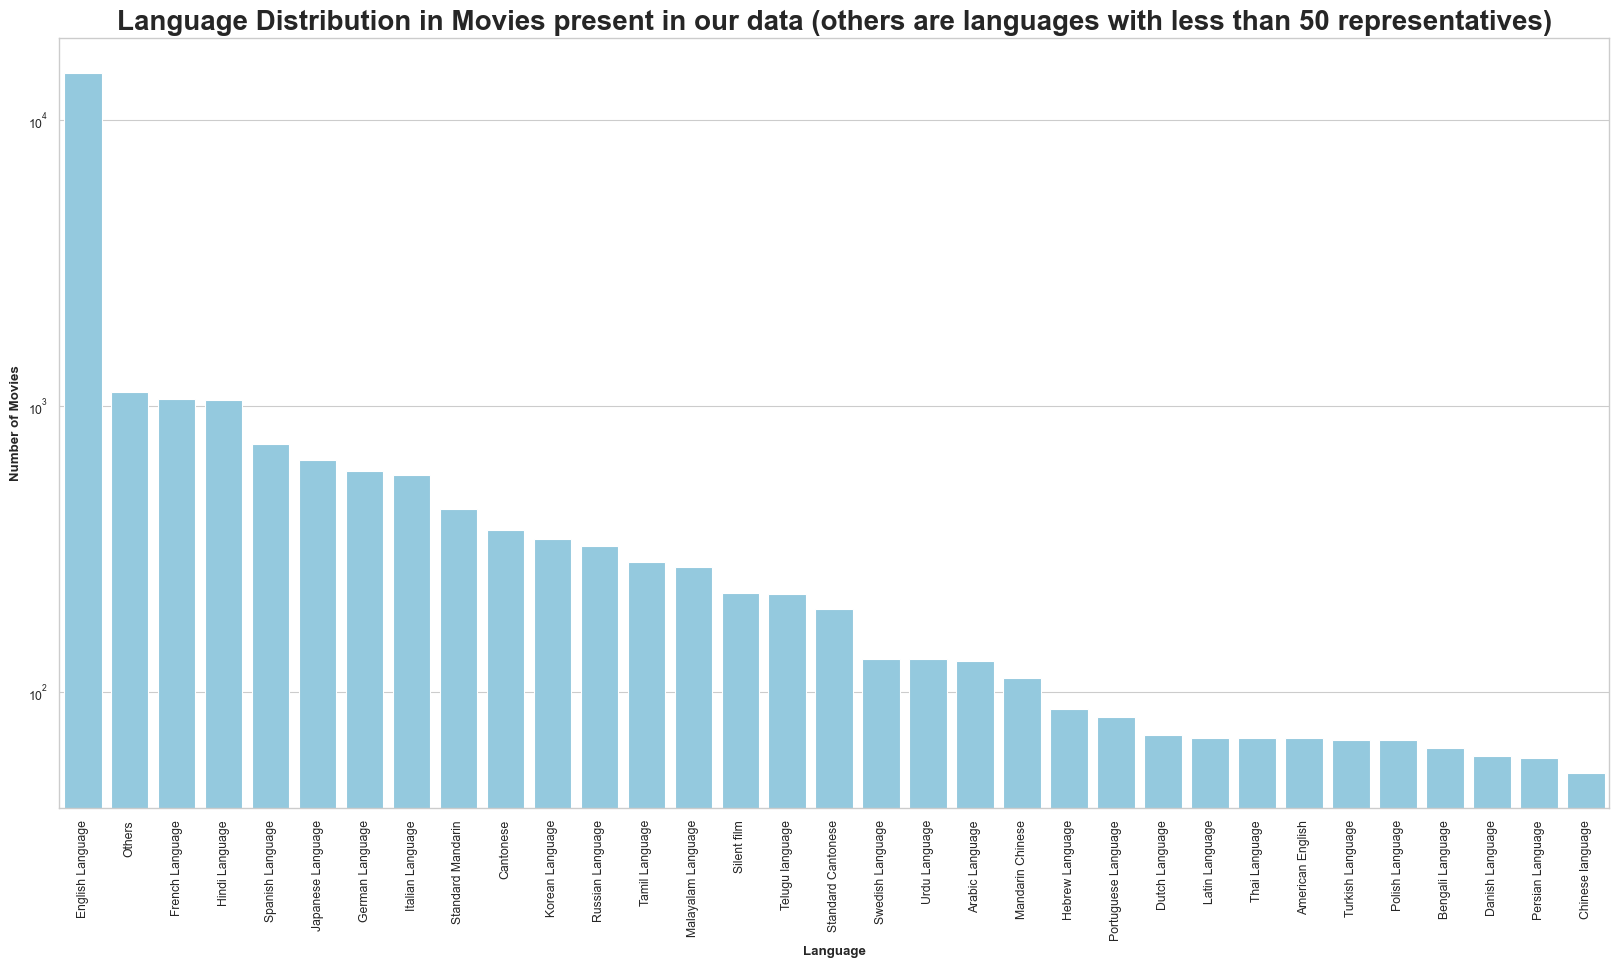

In [32]:
df = languages_ratings_df.copy()
threshold = 50
df.loc[df['language_name'].value_counts()[df['language_name']].values < threshold, 'language_name'] = 'Others'

# plot the histogram with log scale
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title(f'Language Distribution in Movies present in our data (others are languages with less than {threshold} representatives)')
sns.countplot(data=df, 
              x='language_name',
              order=df['language_name'].value_counts().index,
              color='skyblue',
              log=True)
plt.xlabel('Language')
plt.ylabel('Number of Movies')
plt.show()

Now, having the distribution in mind, lets visualize the reception of films by the public via the plot of rating means recieved. In the following plot you can choose the threshold, filtering out languages that have less representatives and also the number of top languages to show. The confidence interval of 95% is shown on each bar.

In [33]:
from ipywidgets import interact, fixed
from ipywidgets import IntSlider

interact(plot_mean_for_languages,
         languages_ratings_df=fixed(languages_ratings_df), 
         threshold=IntSlider(min=2, max=1000, step=50, value=500), 
         top_n=IntSlider(min=3, max=20, step=1, value=5)
)

interactive(children=(IntSlider(value=500, description='threshold', max=1000, min=2, step=50), IntSlider(value…

<function scripts.helper.plot_mean_for_languages(languages_ratings_df, threshold, top_n=10)>

As we can observe, there are languages that seem to be associated with higher ratings, yet this usually comes together with a larger confidence interval. Thus we can't directly jump  to conclusions. However, if we chose the threshold to be large enough, we see that with a rather small confidence interval, certain languages, such as German and French, outperform the English language. This could be linked to the dataset bias, having sampled better quality films in the inernational cases and lower concerning english markets. If this is the case, it might be a good idea to look into the characteristics of films with languages differning from English to find meaningfull insights. 

In [34]:
interact(plot_data, 
         start=IntSlider(value=2000, min=1900, max=2010, step=10), 
         movies_ratings=fixed(movies_metadata_ratings_df), 
         nb_combinations=IntSlider(min=1, max=3, step=1), 
         nb_genres=IntSlider(value=7,min=1, max=15, step=1), 
         nb_combined_genres=IntSlider(min=1, max=4, step=1))

interactive(children=(IntSlider(value=2000, description='start', max=2010, min=1900, step=10), IntSlider(value…

<function scripts.helper.plot_data(start, movies_ratings, nb_combined_genres=1, nb_genres=10)>

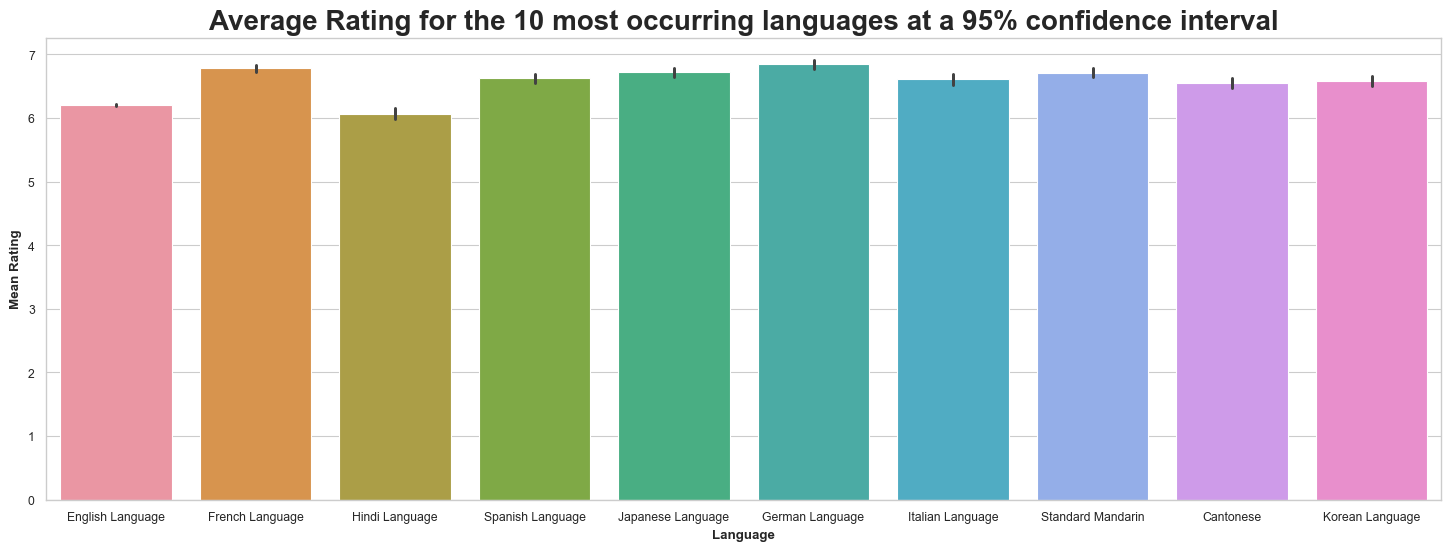

In [35]:
# Group by 'name' and calculate mean and standard deviation
grouped_df = \
    languages_ratings_df.groupby('language_name')['averageRating'].agg(['mean', 
                                                                        'std', 
                                                                        'count'])

# Find the most occurring names
top_names = grouped_df['count'].nlargest(10).index

# Filter the DataFrame for the top names
filtered_df = \
    languages_ratings_df[languages_ratings_df['language_name'].isin(top_names)]

# Group by 'name' again for plotting
plot_data = filtered_df.groupby('language_name')['averageRating']

# Plotting
plt.figure(figsize=(18, 6))
sns.barplot(x='language_name', 
            y='averageRating', 
            data=filtered_df, 
            estimator=np.mean, 
            errorbar=('ci', 95), 
            order=top_names)
plt.xlabel('Language')
plt.ylabel('Mean Rating')
plt.title('Average Rating for the 10 most occurring languages at a 95% confidence interval')
plt.show()

Preforming t-tests showed that if we account leave the english language in the pool of 'other' samples, running a t-test yields a verry small p-value. Removing english shows that some languages tend to get a rather significant p-value, signifying that there may after all be a general tendancy to grade, not specific to each language.

In [36]:
#collecting t-test data on popular languages
languages_to_test =  ['English Language', 
                      'French Language', 
                      'German Language', 
                      'Italian Language', 
                      'Spanish Language', 
                      'Japanese Language', 
                      'German Language', 
                      'Standard Mandarin', 
                      'Korean Language', 
                      'Russian Language', 
                      'Cantonese']

#create an emty map with key language ans value p-value
p_values_with_eng = {}
p_values_without_eng = {}
for language_to_test in languages_to_test:
    p_values_with_eng[language_to_test] = \
        t_test_on_language(language_to_test, languages_ratings_df)[1]
for language_to_test in languages_to_test:
    if language_to_test == 'English Language':
        continue
    p_values_without_eng[language_to_test] = \
        t_test_on_language(language_to_test, languages_ratings_df, elim_English=True)[1]

Performing t-test on differnet languages yields p-values presented in the graph below. For each language we compared the ratings associated to it with the rest of the dataset, having deleted rows with the language being tested.

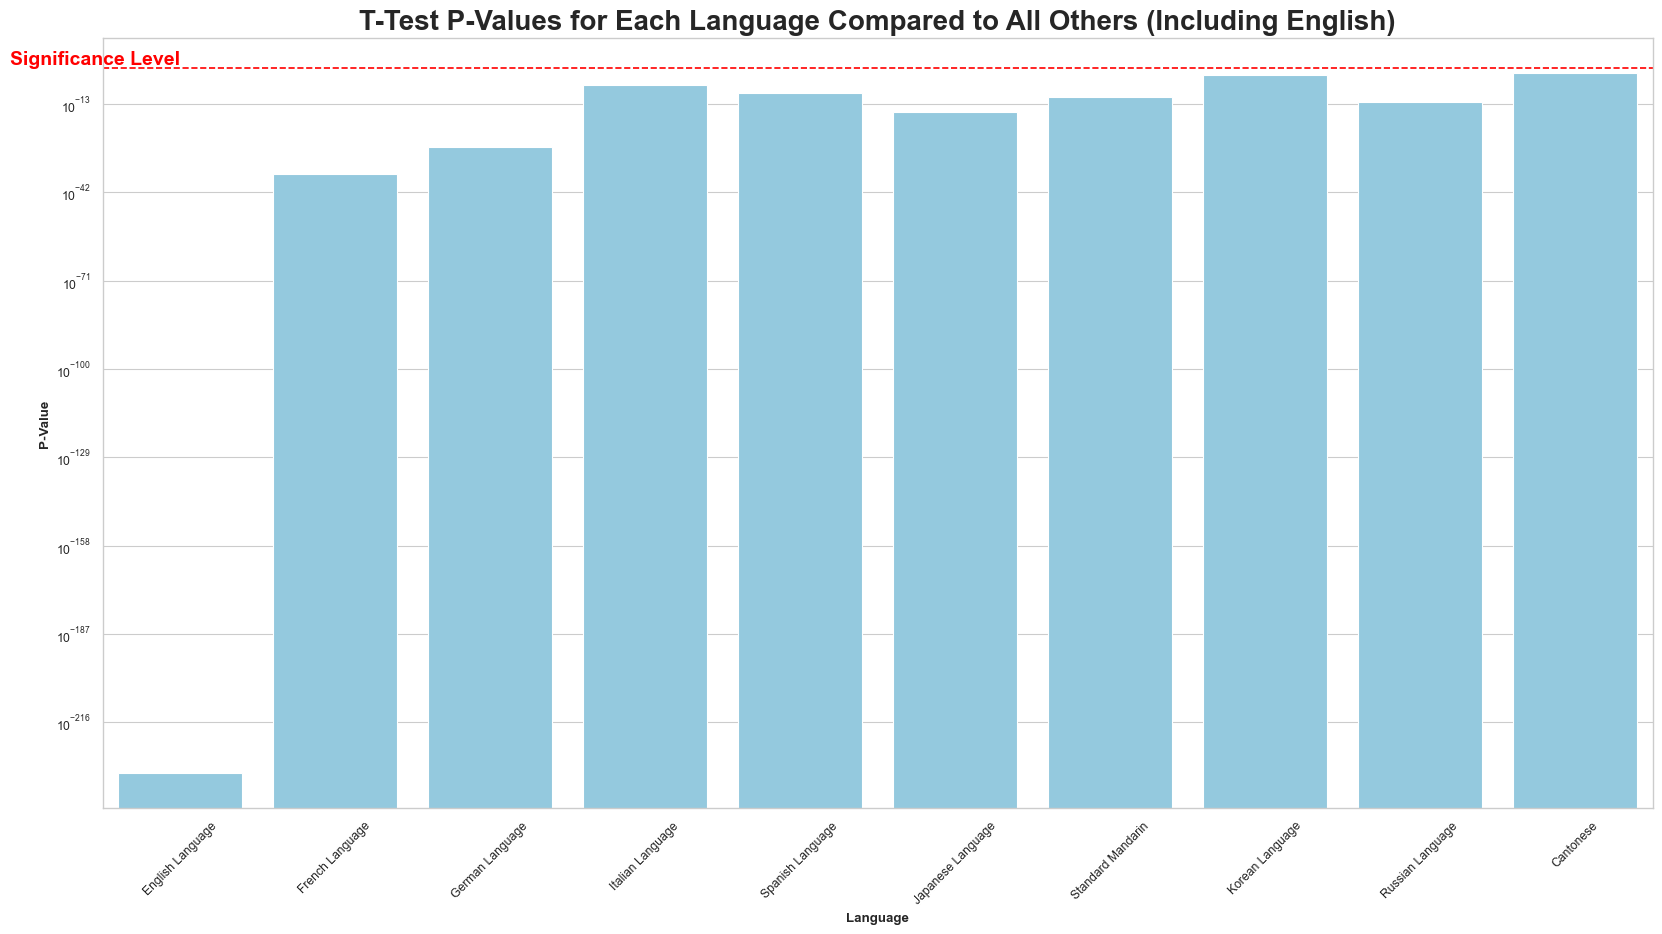

In [37]:
plot_p_values(p_values_with_eng)

As we can see, the p values are very low for all languages, which means that the null hypothesis (that the distribution of the mean rating of the language is the same as the distribution of mean rating of all other languages) is rejected for all languages. This incures that there isn't a geneal law of distributioiin that concerns all languages together. Since the p-value for the english language is orders of magnituds lower, we may suppose that it has a cosiderably different distrigution, however such a feenomena is surely linked to the english language being represented much wider in the dataset, compared to the other languages.

When running an identical procedure but excluding the english language from the data, we get the following plot

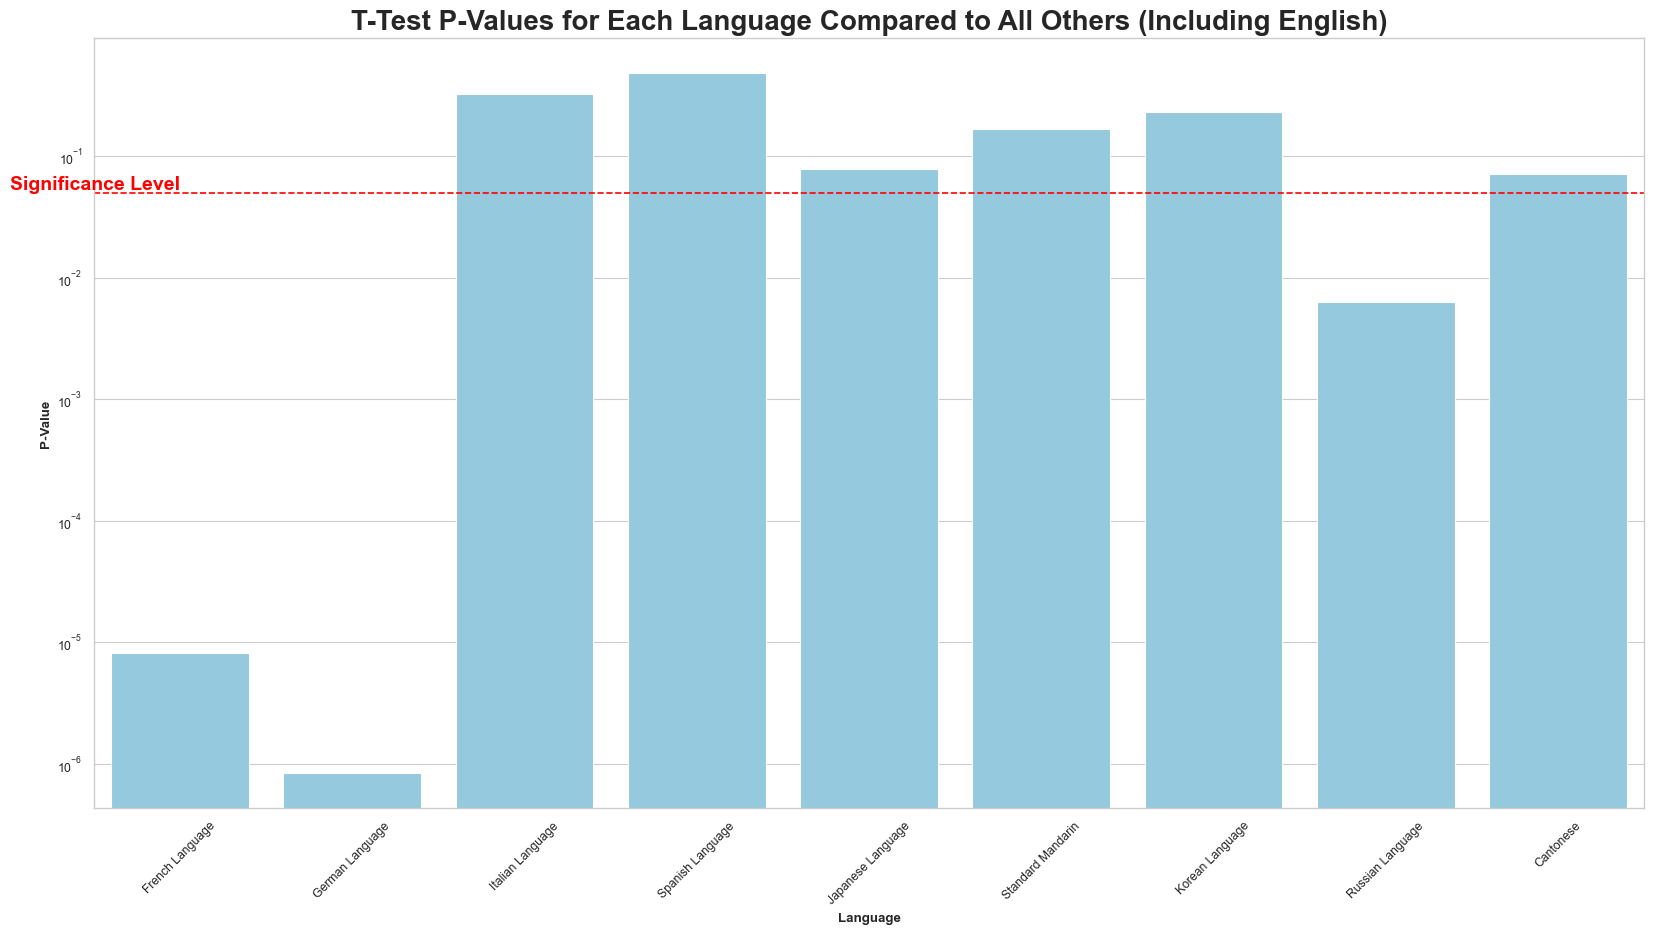

In [38]:
plot_p_values(p_values_without_eng)

Here, we see a less homogenious value, that can be interpreted in a more meaningful insight for finding languages with a distribution differing from the rest of the dataset. However, while some languages tend to have p-value that might support the null hypothesis, those with a larger amount of samples tend to be in the support of the null hypothesis.   

## **2. Keep it Under the Radar!**

Now, one might think that the only way for a movie to get succes on IMDb is to create a huge succes on terms of vues or make it **contreversial** so that it gets more intrest from reviewers. let's analyse this ...

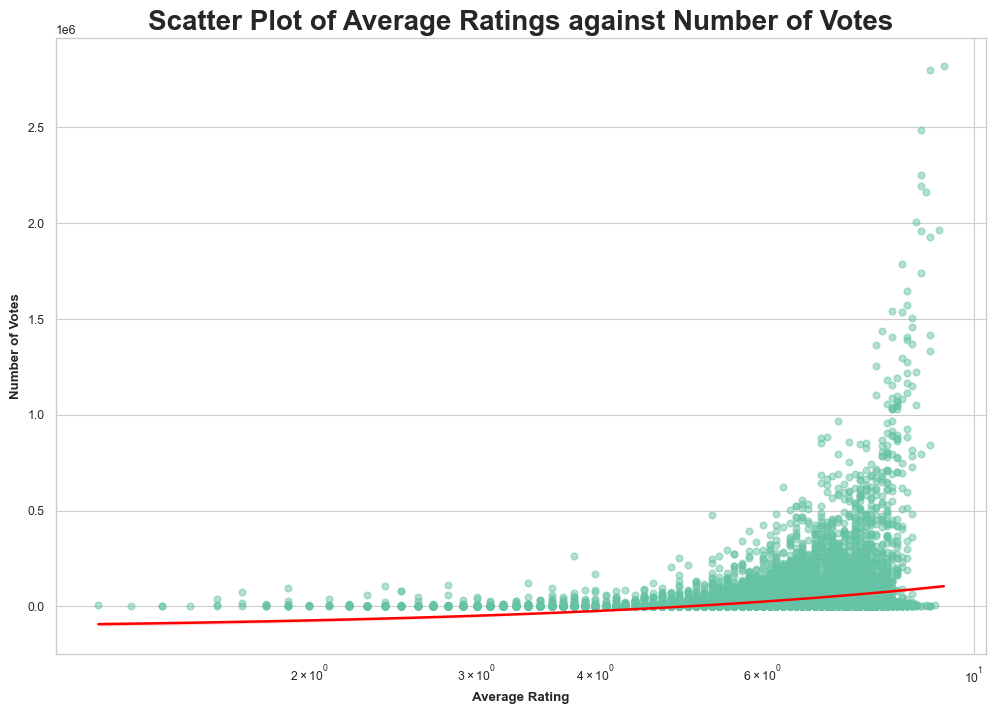

In [39]:
selected_columns = ['numVotes', 'averageRating']
votes_rating_data = movies_metadata_ratings_df[selected_columns]
# Drop rows with missing values (if any)
votes_rating_data = votes_rating_data.dropna()

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.regplot(x='averageRating', 
            y='numVotes', 
            data=votes_rating_data, 
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'})

plt.title('Scatter Plot of Average Ratings against Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.xscale('log')
plt.show()

At first we can see here that High Rating doesn't implicate high number of votes. But let's try to fit a regression line into our data. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


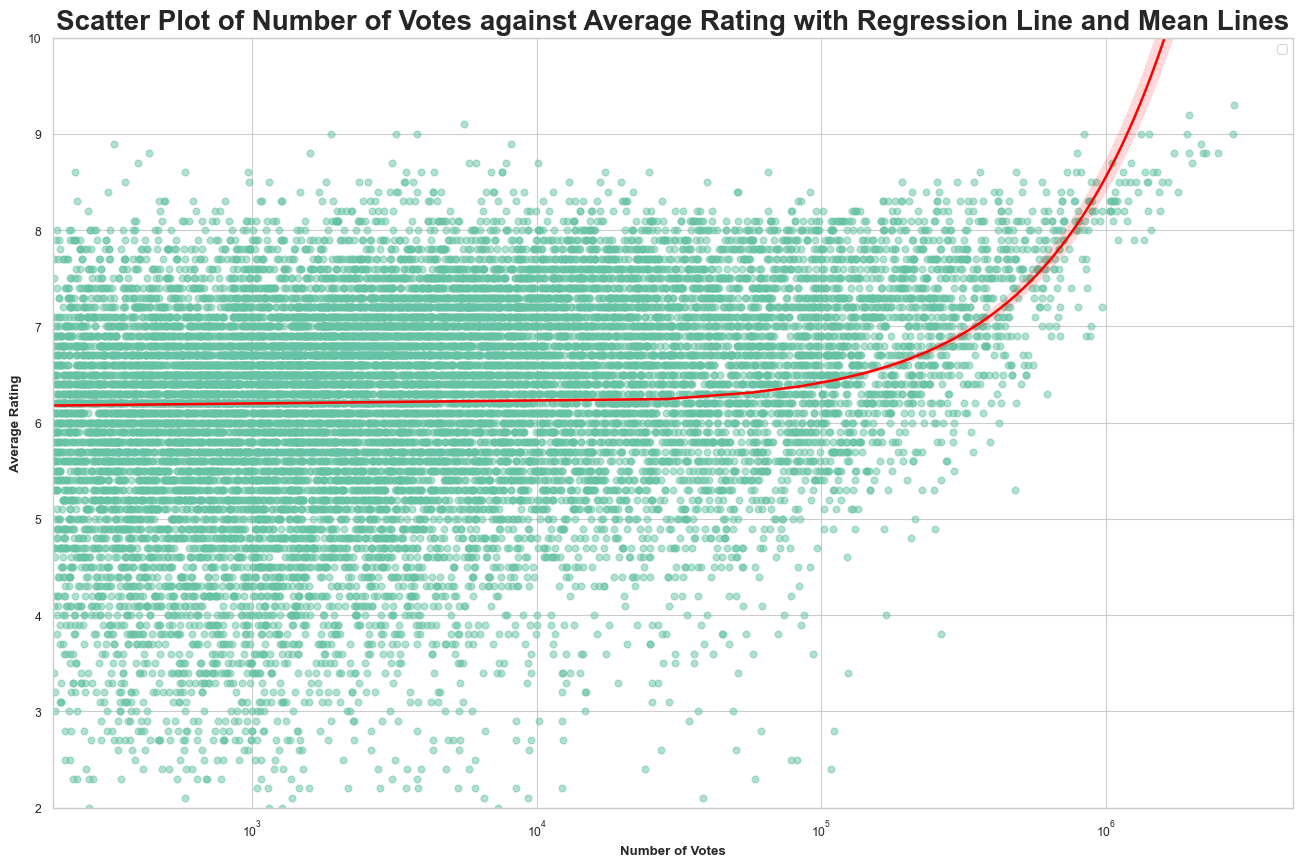

Pearson Correlation Coefficient: 0.24


In [40]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Scatter plot with blue points and red regression line
plt.figure(figsize=(16, 10))
sns.regplot(data=votes_rating_data_df, 
            x='numVotes', 
            y='averageRating', 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red'})

# Calculate moving average for each vote number
window_size = 100  # You can adjust the window size according to your preference
moving_avg_by_vote_number = \
    votes_rating_data_df.groupby('numVotes')['averageRating'].rolling(window=window_size).mean().reset_index(level=0, drop=True)

plt.title('Scatter Plot of Number of Votes against Average Rating with Regression Line and Mean Lines')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.xlim(200)
plt.ylim(2, 10)
plt.ylabel('Average Rating')
plt.legend()  # Show the legend for mean lines
plt.show()

# Calculate Pearson correlation coefficient
correlation_coefficient = \
    votes_rating_data_df['numVotes'].corr(votes_rating_data_df['averageRating'], 
                                          method='pearson')
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


Based on the Pearson Correlation Coefficient of 0.24, we can see that the strength of the linear relationship is weak. This means that while there is a positive trend. the number of votes doesn't influence the average rating. We might need a deeper analysis on the type of distribution we are dealing with. Here the idea is to divide the data inty 5 bins based on the number of votes and see how the rating is distributed in each bin.

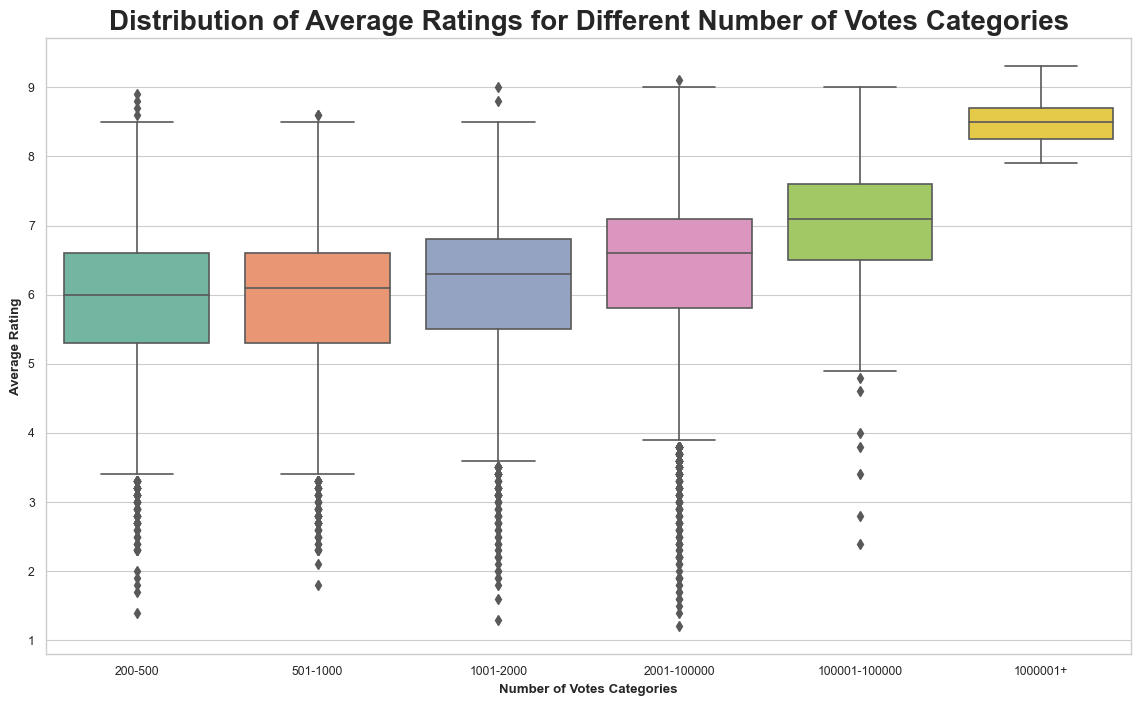

In [41]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Drop rows with missing values (if any)
votes_rating_data_df = votes_rating_data_df.dropna()

# Create a new column for vote number categories (you can adjust the bin edges)
bins = [200, 500, 1000, 2000, 100000, 1000000, float('inf')]
label = ['200-500', '501-1000', '1001-2000', '2001-100000', '100001-100000', '1000001+']
votes_rating_data_df['numVotesCategory'] = \
    pd.cut(votes_rating_data_df['numVotes'], bins=bins, labels=label)

# Create a box plot to compare the distribution of ratings for different vote number categories
plt.figure(figsize=(14, 8))
sns.boxplot(x='numVotesCategory', 
            y='averageRating', 
            data=votes_rating_data_df, 
            order=label)
plt.title('Distribution of Average Ratings for Different Number of Votes Categories')
plt.xlabel('Number of Votes Categories')
plt.ylabel('Average Rating')
plt.show()

Now we can have a clearer conclusion which is that starting at a certain thershold of number of votes the rating will always be high. 

But this also means that under that threshold the number of votes won't affect that much your rating, hence, keeping your movie under the radar might be the best way to increase your rating.

## **3. Movie  era can be a factor**

In [42]:
# Calculate yearly stats across movies 
stats_by_year_df = \
    movies_metadata_ratings_df.groupby(movies_metadata_ratings_df['movie_release_year']).apply(lambda x: pd.Series({
        'average_worldwide_rating': x['averageRating'].mean(),
        'std_dev_worldwide_rating': x['averageRating'].std()}))

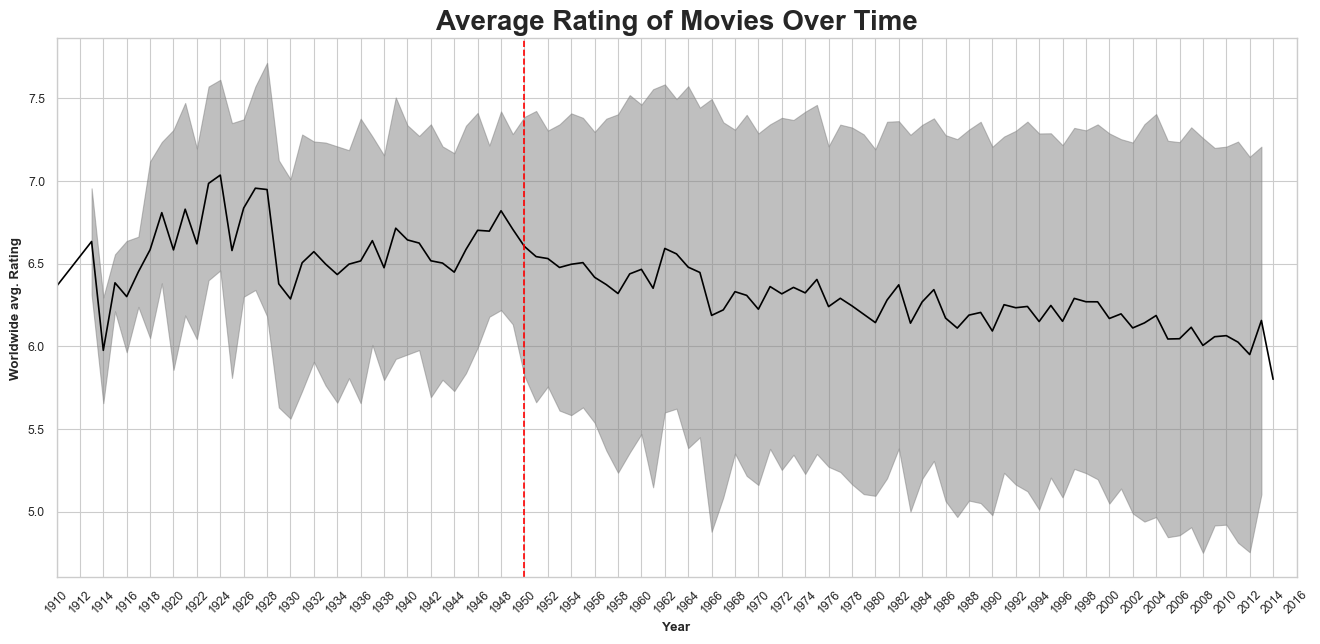

In [43]:
plt.figure(figsize=(16, 7))
plt.fill_between(stats_by_year_df.index, 
                 stats_by_year_df.average_worldwide_rating - stats_by_year_df.std_dev_worldwide_rating,
                 stats_by_year_df.average_worldwide_rating + stats_by_year_df.std_dev_worldwide_rating, 
                 alpha = 0.5, 
                 color = 'gray')

plt.plot(stats_by_year_df.average_worldwide_rating, color = 'black')
plt.axvline(x=1950, color='red', linestyle='--', label='Transition to colored movies')

plt.xlabel('Year')
plt.xlim(1910, 2016)
plt.xticks(range(1910, 2016 + 1, 2))
plt.xticks(rotation=45)
plt.ylabel('Worldwide avg. Rating')
plt.title('Average Rating of Movies Over Time')
plt.show()

From this plot, we can conclude that ratings are in a decreasing trend, so if your movie wasn't released in the early 90's it is unlikely that you can hack the system.
Another intresting insight from this plot is that this trend began on 1950s, the years that marked a more widespread adoption of color in the film industry. 
You might need to use black and white visuals in your production to take advantage of this fact.

In [44]:
movies_metadata_ratings_years_df = \
    movies_metadata_ratings_df[['movie_release_year','averageRating']]

movie_before_1950_df = \
    movies_metadata_ratings_years_df[movies_metadata_ratings_years_df['movie_release_year'] < 1950]['averageRating']
movie_after_1950_df = \
    movies_metadata_ratings_years_df[movies_metadata_ratings_years_df['movie_release_year'] >= 1950]['averageRating']

movie_before_after_1950_df = \
    pd.DataFrame({'before_1950': movie_before_1950_df, 
                  'after_1950': movie_after_1950_df})

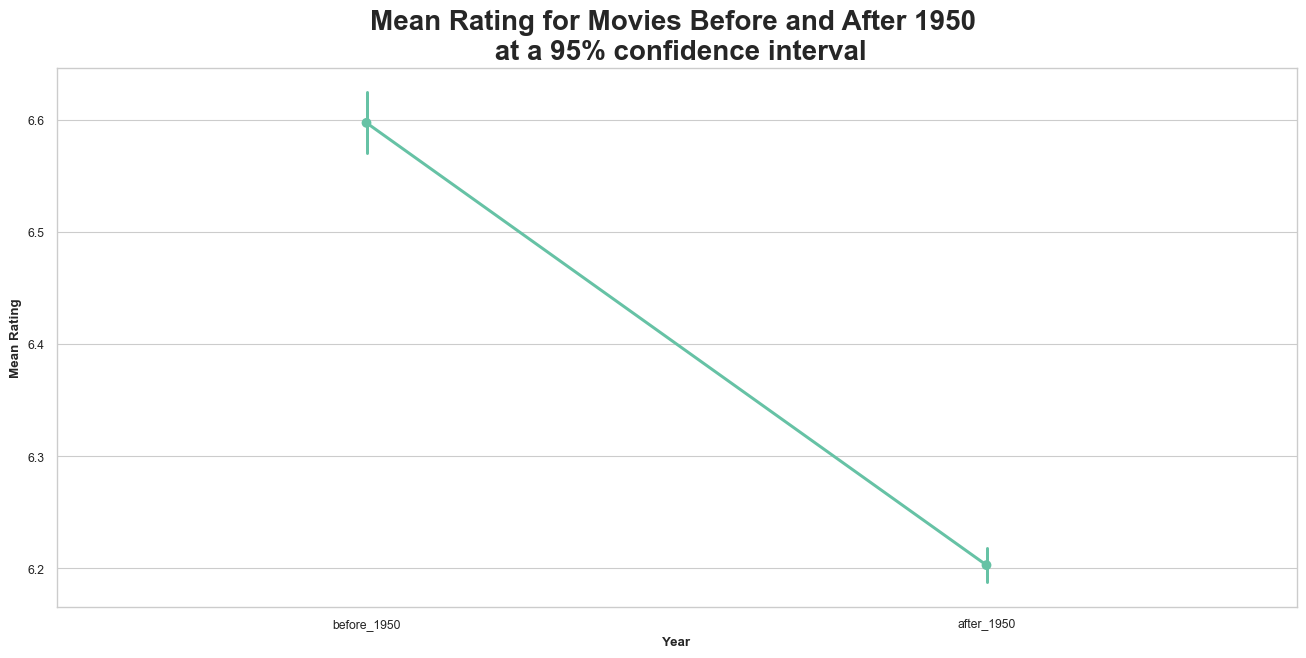

In [45]:
# Plot the mean rating for movies before and after 1950
plt.figure(figsize=(16, 7))
sns.pointplot(data=movie_before_after_1950_df,  
              errorbar=("ci", 95))

plt.title("Mean Rating for Movies Before and After 1950 \n at a 95% confidence interval")
plt.xlabel("Year")
plt.ylabel("Mean Rating")
plt.grid(axis='y', linestyle='-')
plt.show()

In [46]:
_,p_value = stats.ttest_ind(movie_before_1950_df, movie_after_1950_df)
print(f"p-value for t-test on films before 1950 and after: {p_value}")

p-value for t-test on films before 1950 and after: 1.5772968896393338e-65


- The p-value is of magnitude -65, which is less than 0.05. We can reject the null hypothesis that the distribution of ratings is the same for movies released before and after 1950.

Now, we can conclude that the year of release is a factor that can affect the rating of a movie. Or at least the way it was filmed can affect the rating and that people tend to prefer older movies.

## **4. Movie runtime and average rating**

We define the `movie_runtime_rating_df` dataframe, which contains the runtime and the averageRating of each movie

In [47]:
movie_runtime_rating_df = \
    movies_metadata_ratings_df[['movie_runtime','averageRating']]
filtered_movie_runtime_rating_df = \
    movie_runtime_rating_df[movie_runtime_rating_df['movie_runtime'] < 400]
movie_runtime_rating_df.head()

,movie_runtime,averageRating
0,98.0,4.9
3,106.0,5.9
8,137.0,7.5
9,139.0,7.8
13,82.0,6.1


Now we create a jointplot to visualise the relationship between the movie runtime and the avetage rating along with their individual distributions

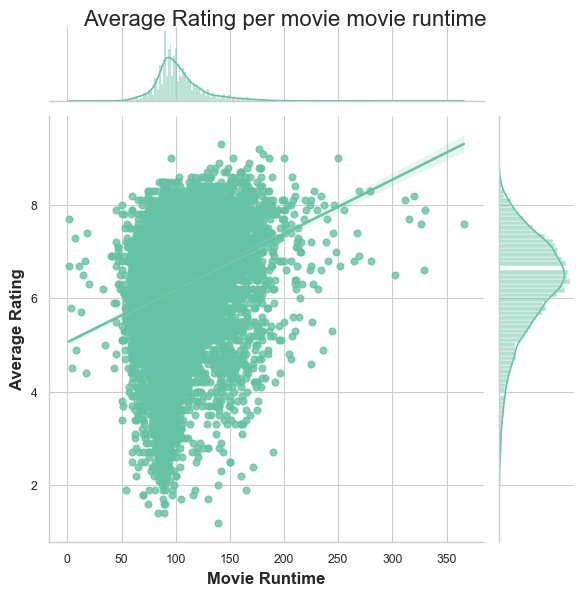

In [48]:
g = sns.jointplot(x=filtered_movie_runtime_rating_df['movie_runtime'], 
                  y=filtered_movie_runtime_rating_df['averageRating'], 
                  kind='reg', 
                  height=6)

# Set labels and title
g.set_axis_labels('Movie Runtime', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie movie runtime ', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [49]:
#performing an ols on the movie runtime of each movie
reg = smf.ols('averageRating ~ movie_runtime', 
              data=filtered_movie_runtime_rating_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1356.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          7.92e-287
Time:                        07:45:17   Log-Likelihood:                -27827.
No. Observations:               19224   AIC:                         5.566e+04
Df Residuals:                   19222   BIC:                         5.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0605      0.033    151.072

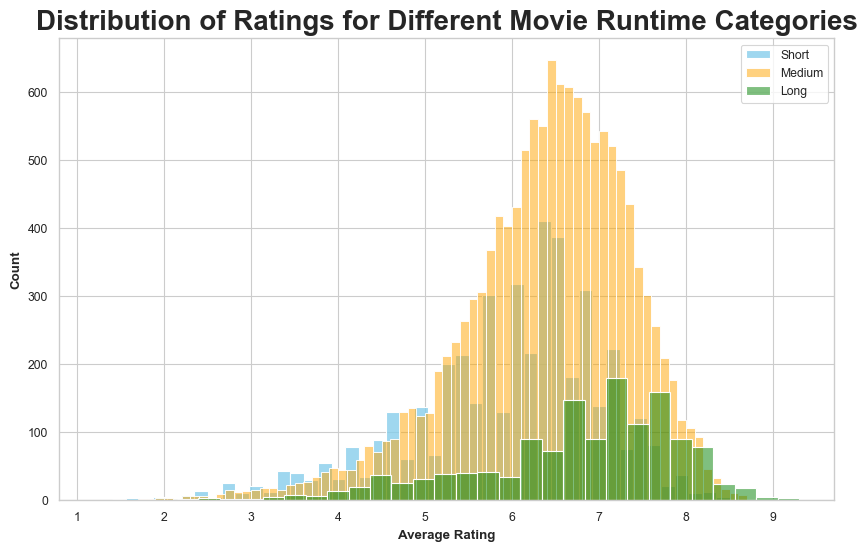

In [50]:
short_df = filtered_movie_runtime_rating_df[filtered_movie_runtime_rating_df['movie_runtime'] < 90]
medium_df = filtered_movie_runtime_rating_df[(filtered_movie_runtime_rating_df['movie_runtime'] >= 90) & (filtered_movie_runtime_rating_df['movie_runtime'] <= 140)]
long_df = filtered_movie_runtime_rating_df[filtered_movie_runtime_rating_df['movie_runtime'] > 140]

# Plot the distribution of ratings for each category using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(short_df['averageRating'], label='Short', kde=False, color='skyblue', alpha=0.8)
sns.histplot(medium_df['averageRating'], label='Medium', kde=False, color='orange', alpha=0.5)
sns.histplot(long_df['averageRating'], label='Long', kde=False, color='green', alpha=0.5)

# Set plot labels and title
plt.title('Distribution of Ratings for Different Movie Runtime Categories')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.legend()
plt.show()

### **Interpretation**

The R-squared value of 0.066 and a significant F-statistic p-value suggest that there is a statistically significant relationship between movie runtime and average rating. But movie runtime explains only a small portion of the variability in ratings. Specifically, the 0.0116 coefficient indicates a slight positive relationship: as movie runtime increases, the average rating tends to increase marginally.

Most movies runtimes tend to be in the range 90 to 150 minutes. one might think that the optimal runtime for higher ratings is around 100 to 120 minutes: not too long that it risks losing the audience's attention and not too short to be sufficient enough to develop the plot and characters.

But our analysis indicates that the best bet is a long movie

## **5. Large Revenue Corelation With The IMDB Ratings**

One might think that the IMDb rating is strictly correlated to the revenue. We investigate this hypothesis by plotting a jointplot to highlight the distribution of the average rating in relation with the movie revenue.

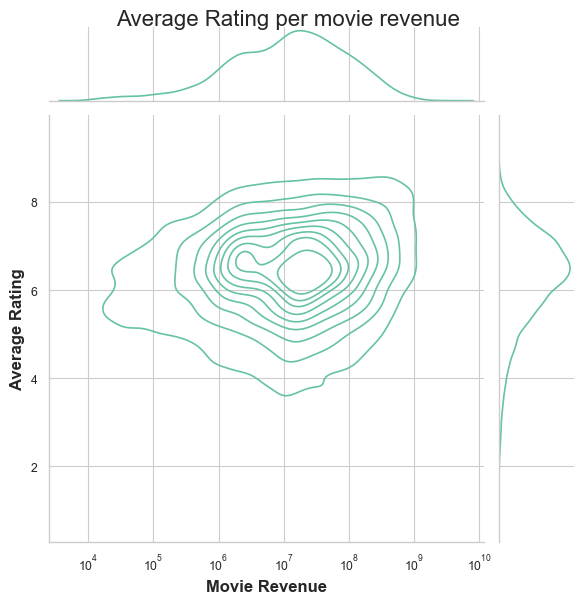

In [51]:
# plot the average rating per movie revenue
g = sns.jointplot(x=movies_metadata_ratings_df['movie_box_office_revenue'],
              y=movies_metadata_ratings_df['averageRating'],
              kind='kde',
              height=6,
              log_scale=(True, False))

# Set labels and title
g.set_axis_labels('Movie Revenue', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie revenue', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [52]:
#perform an ols on the movie revenue of each movie
reg = smf.ols('averageRating ~ movie_box_office_revenue', 
              data=movies_metadata_ratings_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     198.8
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.71e-44
Time:                        07:45:26   Log-Likelihood:                -9032.0
No. Observations:                6601   AIC:                         1.807e+04
Df Residuals:                    6599   BIC:                         1.808e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### **Interpretation**

One might think that movies with a high box office revenue are for sure movies that people tend to like more but the reality is deceiving.

We can see from the plot above and from the regression that the coefficient is nearly 0 wich means that there is no correlation between the box office revenue and the IMDb rating which is surprizing. This indicates the power of marketing in the movie industry.

## **6. Countries effect on movie ratings** 

Now, we want to see if there's a connection between how people rate movies on IMDb and where those movies come from.

We define the `movie_country_rating_df` dataframe, which contains the countries of movies and the IMDb ratings. We construct this dataframe by reading the `movie_countries` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of country_id and country_name. We then extract the country_name and add it to the a new column called `country_name`.

In [53]:
movie_country_rating_df = \
    movies_metadata_ratings_df[['wiki_movie_id', 
                                'movie_name', 
                                'movie_countries', 
                                'averageRating']]

movie_country_rating_df['movie_countries'] = \
    movie_country_rating_df['movie_countries'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
movie_country_rating_df = movie_country_rating_df.explode('movie_countries')

# Rename the column and select only the required columns
movie_country_rating_df = \
    movie_country_rating_df.rename(columns={'movie_countries': 'country_name'})[['wiki_movie_id',
                                                                                 'movie_name', 
                                                                                 'country_name', 
                                                                                 'averageRating']]

movie_country_rating_df = \
    movie_country_rating_df[movie_country_rating_df['country_name'].notna()]
movie_country_rating_df.reset_index(drop=True, inplace=True)
movie_country_rating_df

country_coordinates = pd.read_csv('data/GENERATED_DATA/country_coordinates.csv')

country_coordinates_ratings_df = pd.merge(movie_country_rating_df, 
                                          country_coordinates, 
                                          on='country_name')

# Group by 'startYear' and 'country_name'
country_coordinates_ratings_df = \
    country_coordinates_ratings_df.groupby(['country_name', 'latitude', 'longitude'])

# Aggregate data
average_rating_by_country_and_year_df = \
    country_coordinates_ratings_df['averageRating'].mean().reset_index()

# print average rating by country and year size
print(f"Size of the avearge_rating_by_country_and_year_df: {average_rating_by_country_and_year_df.shape}")
average_rating_by_country_and_year_df.sample(5)

Size of the avearge_rating_by_country_and_year_df: (128, 4)


,country_name,latitude,longitude,averageRating
101,Slovakia,48.7,19.7,6.650000
81,Pakistan,30.3,69.3,7.180000
29,Egypt,27.0,30.0,6.200000
53,Italy,42.5,12.5,6.461514
127,Zimbabwe,-19.0,29.1,6.150000


In [54]:
import folium
from branca.colormap import LinearColormap

# Assuming average_rating_by_country_and_year_df is your final DataFrame after data processing

# Custom color scale - more intense contrast from light yellow to deep red
color_scale = LinearColormap(['red', 'orange', 'yellow', 'lightgreen', 'green'],
                             vmin=average_rating_by_country_and_year_df['averageRating'].min(),
                             vmax=average_rating_by_country_and_year_df['averageRating'].max())

# Initialize the map
map = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for each country
for _, row in average_rating_by_country_and_year_df.iterrows():
    # Calculate the radius based on the average rating (adjustable factor)
    radius = 3 + (row['averageRating'] - average_rating_by_country_and_year_df['averageRating'].min())

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup="{}: {:.2f}".format(row['country_name'], row['averageRating']),
        color=color_scale(row['averageRating']),
        fill=True,
        fill_opacity=0.7,
        tooltip=f"{row['country_name']}: {row['averageRating']:.2f}"
    ).add_to(map)

# Display the map
map

We can notice from the world map that the avearge rating of the united states is pretty low (6.15) since it is the country that produces the most movies. countries like slovenia,cambodia and sri lanka for example seem to have a higher ratings. this could be explained by two things:

People that rate movies from their countries are biased, meaning that they tend to vote for a higher rating if the movie is from their country
movies from the united states are more wildely distributed so the opinions could vary more.

Movies from the US are more wildely distributed so the opinions could vary more.

## **7. Linking events to movies** 

In this section we are going to try to link movie summaries with historical events, to do that we chose to use the BERT-Large model from hugging face.
- First we tokenize the event description, then we compute the embeddings for this description
- Then we tokenize the summary and we compute the embeddings for this summary

In [55]:
events_embeddings_filename = 'data/EMBEDDINGS/events_embeddings.csv'
plot_summaries_embeddings_filename = 'data/EMBEDDINGS/plot_summaries_embeddings.csv'

In [56]:
# we run the embedding is  in another notebook because it takes 20 h to run :)

Create event description embeddings

In [57]:
if not os.path.exists(events_embeddings_filename):
    # Tokenize, encode, and get embeddings
    events_df['Embeddings'] = \
        events_df['Event Description'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)
    
    #save the embeddings of events as a csv file
    events_df.to_csv('data/RESULTS/events_embeddings.csv', index=False)

Create movie summary plot emberddings

In [58]:
if not os.path.exists(plot_summaries_embeddings_filename):
    # add a column to the plot_summaries_df with embedding of the summary
    plot_summaries_df['Embeddings'] = \
        plot_summaries_df['plot_summary'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)

    #save the embeddings of summaries as a csv file
    plot_summaries_df.to_csv('data/plot_summaries_embeddings.csv', index=False)

Load the event embeddings and summaries embeddings

In [59]:
events_embedded_df = pd.read_csv(events_embeddings_filename)
# Convert string representation back to tensor
events_embedded_df['Embeddings'] = \
    events_embedded_df['Embeddings'].apply(string_to_tensor)

summaries_embedded_df = pd.read_csv(plot_summaries_embeddings_filename)
# Convert string representation back to tensor
summaries_embedded_df['Embeddings'] = \
    summaries_embedded_df['Embeddings'].apply(string_to_tensor)

We create some helper functions

In [60]:
#create a merged dataset with the movie metadata and the summaries(with the embeddings)
merged_movie_df = pd.merge(summaries_embedded_df, 
                           movies_metadata_ratings_df, 
                           on='wiki_movie_id', 
                           how='inner')

Lastly we compare the embedding of the movie summary with all the events embeddings and we pick the event that matches the most.

In [61]:
linked_movies_and_events_filename = 'data/RESULTS/linked_movies_and_events_df.csv'

if not os.path.exists(linked_movies_and_events_filename):
    # Initialize an empty list to store movie data
    linked_movies_events = []

    # Loop through each movie
    for index, movie in merged_movie_df.iterrows():
        # Your existing logic to get movie_embedding, movie_release_year, similarity, and matched_event
        movie_embedding = movie['Embeddings']
        movie_release_year = movie['movie_release_year']
        similarity, matched_event = \
            match_event_from_summary_embeddings(events_embedded_df, movie_embedding, movie_release_year)
        event_description = events_df[events_df['Event Name'] == \
                                      matched_event]['Event Description'].values[0]

        # Create a dictionary for the current movie
        movie_data = {
            'wiki_movie_id': movie['wiki_movie_id'],
            'movie_name': movie['movie_name'],
            'plot_summary': movie['plot_summary'],
            'matched_event': matched_event,
            'event description': event_description,
            'similarity_score': similarity,
            'rating': movie['averageRating']
        }

        # Append the dictionary to the list
        linked_movies_events.append(movie_data)

    # Create a DataFrame from the list of dictionaries
    linked_movies_and_events_df = pd.DataFrame(linked_movies_events)

    #save the dataframe to csv
    linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

In [62]:
# the comparison is made in another notebook (takes about 30 minutes to run)

After running the Bert model to get the embeddings and assigning each movie to an event we read the resulting file 
- After inspecting manually the results we chose a thresholf of 0.77 to be the thresholf of considering a movie as related to a real world event.

In [63]:
# read the linked_movies_and_events_df 
linked_movies_and_events_df = pd.read_csv(linked_movies_and_events_filename)

linked_movies_and_events_df.sort_values(by=['similarity_score'], ascending=False, inplace=True)

#save the dataframe to csv
linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

movies_related_to_events_df = \
    linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] > 0.77]

movies_unrelated_to_events_df = \
    linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] < 0.77]

We calculate the average rating for movies considered related to a real world event and for those consiodered as not related to movie events and perform a t-test.

In [64]:
average_rating_all = linked_movies_and_events_df['rating'].mean()
average_rating_related = movies_related_to_events_df['rating'].mean()
average_rating_unrelated = movies_unrelated_to_events_df['rating'].mean()
print('Average rating of movies related to events:', average_rating_related)
print('Average rating of movies unrelated to events:', average_rating_unrelated)
print('Average rating of movies', average_rating_all)

# perform the t-test
stats.ttest_ind(movies_related_to_events_df['rating'], 
                movies_unrelated_to_events_df['rating'])

print('p-value: ', 
      stats.ttest_ind(movies_related_to_events_df['rating'], 
                      movies_unrelated_to_events_df['rating'])[1])

Average rating of movies related to events: 6.31342229199372
Average rating of movies unrelated to events: 6.247167520194286
Average rating of movies 6.251343062082611
p-value:  0.03441312168912531


We can see that the p-value is less than 0.05 so we can reject the null hyposesis.
- We can interpret that the fact that a movie is related to a historical event improves the IMDb rating.

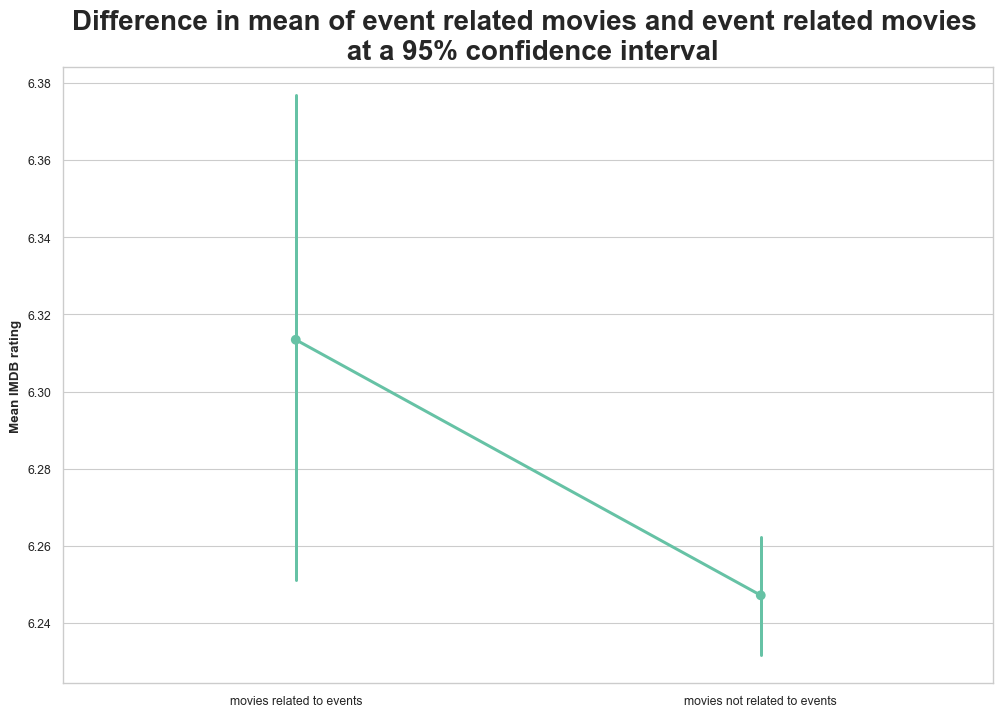

In [65]:
related_unrelated_movies = \
    pd.DataFrame({'movies related to events': movies_related_to_events_df['rating'] , 
                  'movies not related to events': movies_unrelated_to_events_df['rating']})

plt.figure(figsize=(12, 8))
# plot the mean salary for each throwing hand
sns.pointplot(data=related_unrelated_movies, errorbar=("ci", 95))
plt.title("Difference in mean of event related movies and event related movies \n at a 95% confidence interval")
plt.ylabel("Mean IMDB rating")
plt.grid(axis='y', linestyle='-')
plt.show()

## **8. Evaluate the effect of Oscars nominations and wins on movie sucess**

### **Nominated actors impact**

We define the `character_nomination_year_df` dataframe, which contains the actor name and the movie release year.

In [66]:
# keep freebase_character_id, actor_name, movie_release_year columns only
character_nomination_year_df = \
    character_metadata_award_df[['freebase_character_id',
                                 'actor_name', 
                                 'movie_release_year']]

print("Size of the character_award_year_df:", character_nomination_year_df.shape)
character_nomination_year_df.sample(5)

Size of the character_award_year_df: (1452, 3)


,freebase_character_id,actor_name,movie_release_year
899,/m/02nw81h,Ed Harris,1995.0
825,/m/02nwdqv,Liv Ullmann,1976.0
632,/m/0h_j6z5,Terence Stamp,1962.0
1080,NaN,Maurice Chevalier,1930.0
1298,/m/02nwn4h,Robert Duvall,1983.0


We create a subset of the `character_metadata_df` dataframe called `character_subset_df`. This subset contains the following columns: `wiki_movie_id`, `actor_name`, and `movie_release_year`.

In [67]:
# keep wiki_movie_id, actor_name, movie_release_year columns only
character_subset_df = \
    character_metadata_df[['wiki_movie_id', 
                           'freebase_character_id', 
                           'actor_name', 
                           'movie_release_year']]

# drop na in movie_release_year
character_subset_df = \
    character_subset_df[character_subset_df['movie_release_year'].notna()]

print("Size of the character_subset_df:", character_subset_df.shape)
character_subset_df.sample(5)

Size of the character_subset_df: (192540, 4)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year
236950,534778,NaN,Burke Byrnes,1991.0
391628,4568737,/m/0dbxhlc,Jaya Bhaduri Bachchan,1971.0
188577,24511133,NaN,Daniela Mercado,2010.0
34819,1679152,/m/05kkbvp,Gary Busey,1985.0
275499,31835516,NaN,Iselin Steiro,2011.0


We merge `character_subset_df` and `character_award_year_df` dataframes based on the `freebase_character_id` and `actor_name` columns. 

Next, we try to know if a nominated actor is staring in a movie, does this movie get a higher rating than a movie that doesn't have a nominated actor.

In [68]:
character_subset_nomination_year_df = pd.merge(character_subset_df, 
                                               character_nomination_year_df, 
                                               on=['freebase_character_id', 'actor_name'], 
                                               how='left', 
                                               suffixes=('', '_nominated'))

# remove rows there movie_release_year_nominated is na
character_subset_nomination_year_df = \
    character_subset_nomination_year_df[character_subset_nomination_year_df['movie_release_year_nominated'].notna()]

character_subset_nomination_year_df['nominated'] = \
    character_subset_nomination_year_df['movie_release_year'] > character_subset_nomination_year_df['movie_release_year_nominated']

# remove columns movie_release_year_nominated
character_subset_nomination_year_df.drop(columns=['movie_release_year_nominated'], inplace=True)

print("Size of the character_subset_nomination_year_df:", character_subset_nomination_year_df.shape)
character_subset_nomination_year_df.sample(5)

Size of the character_subset_nomination_year_df: (5883, 5)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,nominated
75045,3497579,NaN,Billie Burke,1949.0,True
75870,161897,/m/05z33nm,George Kennedy,1967.0,False
18614,7129971,NaN,Adolph Caesar,1980.0,False
122073,5134517,NaN,Chill Wills,1949.0,False
97608,9459581,NaN,Charles Coburn,1953.0,True


We create a ´movie_metadata_nominated_df´ dataframe, which contains the average rating of each movie and a column that indicates the number of nominated actors in each movie.

The `nominated_actors` column indicates the number of actors that have been nominated.

In [69]:
#count the number of nominations for each movie
character_subset_nomination_year_df['nominated_actors'] = \
    character_subset_nomination_year_df.groupby('wiki_movie_id')['nominated'].transform('sum')

#remove nominated column
character_subset_nomination_year_df.drop(columns=['nominated'], inplace=True)

#merge the character_subset_nomination_year_df with the movie_metadata_rating_df
movie_metadata_nominated_df = pd.merge(movie_metadata_rating_df[['wiki_movie_id', 'averageRating', 'movie_box_office_revenue']],
                                       character_subset_nomination_year_df,
                                       on='wiki_movie_id', 
                                       how='inner')

print("Size of the movie_metadata_nominated_df:", movie_metadata_nominated_df.shape)
movie_metadata_nominated_df.sample(5)

Size of the movie_metadata_nominated_df: (5902, 7)


,wiki_movie_id,averageRating,movie_box_office_revenue,freebase_character_id,actor_name,movie_release_year,nominated_actors
9,1369204,6.9,NaN,NaN,Paul Muni,1939.0,4
4344,5566931,7.0,NaN,NaN,Wallace Beery,1923.0,0
995,1591874,7.4,2750000.0,NaN,Shelley Winters,1954.0,3
246,2154180,6.7,NaN,NaN,Melvyn Douglas,1977.0,3
3803,161880,7.8,NaN,/m/02nwg7x,Paul Newman,1963.0,0


Now we plot the average rating of the movies compared to the number of nominated actors in each movie.

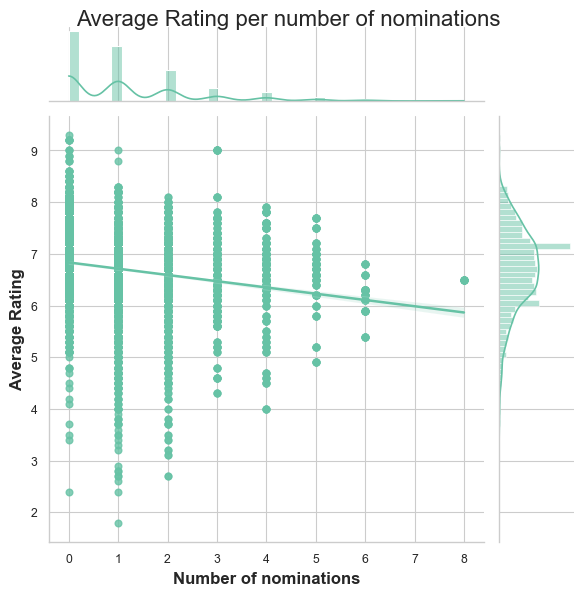

In [70]:
#plot the joint plot of the average rating and the number of nominations
g = sns.jointplot(x=movie_metadata_nominated_df['nominated_actors'], 
                  y=movie_metadata_nominated_df['averageRating'],
                  kind='reg',
                  height=6)

# Set labels and title
g.set_axis_labels('Number of nominations', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per number of nominations', fontsize=16)
g.fig.subplots_adjust(top=0.95)
plt.show()

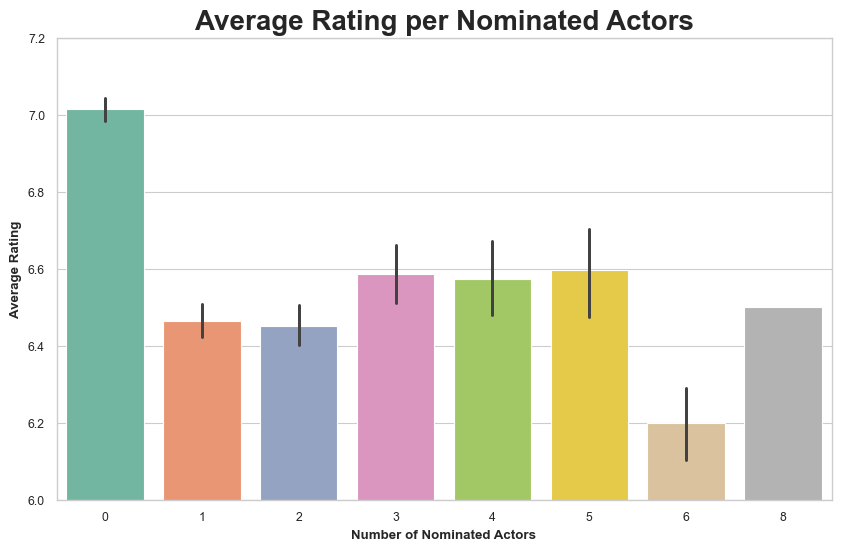

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(x='nominated_actors', 
            y='averageRating', 
            data=movie_metadata_nominated_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Nominated Actors')
plt.ylabel('Average Rating')
plt.ylim(6, 7.2)
plt.title('Average Rating per Nominated Actors')
plt.show()

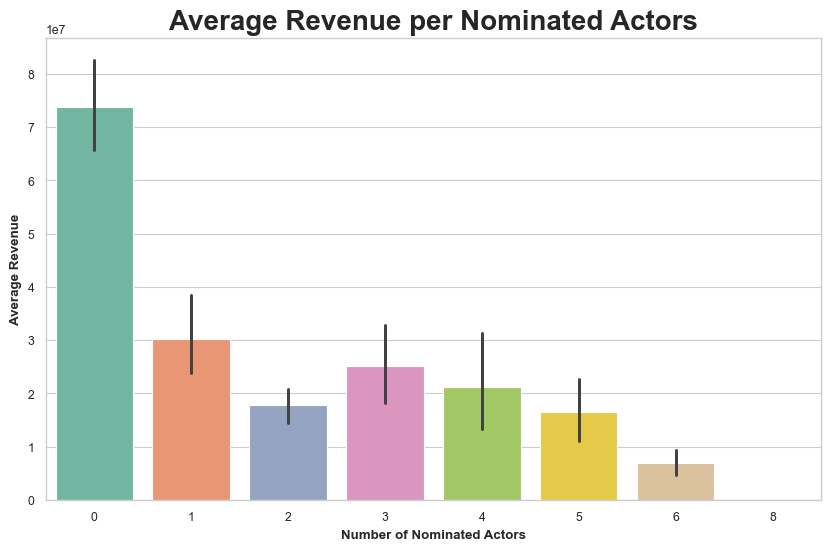

In [72]:
plt.figure(figsize=(10, 6))
sns.barplot(x='nominated_actors', 
            y='movie_box_office_revenue', 
            data=movie_metadata_nominated_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Nominated Actors')
plt.ylabel('Average Revenue')
plt.title('Average Revenue per Nominated Actors')
plt.show()

In [73]:
#perform an ols on the number of nominations of each movie
reg = smf.ols('averageRating ~ nominated_actors', 
              data=movie_metadata_nominated_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     238.0
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.12e-52
Time:                        07:45:47   Log-Likelihood:                -7274.6
No. Observations:                5902   AIC:                         1.455e+04
Df Residuals:                    5900   BIC:                         1.457e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.8337      0.014  

### **Winning actors impact**

We define the `character_metadata_winner_df` dataframe, which contains only the actors that won the oscars.
We also define the `character_winning_year_df` dataframe from the later one, which contains the actor name and the movie release year.

In [74]:
# drop characters that did not win an oscar
character_metadata_winner_df = \
    character_metadata_award_df[character_metadata_award_df['winner'] == True]

# keep freebase_character_id, actor_name, movie_release_year columns only
character_winner_year_df = \
    character_metadata_winner_df[['freebase_character_id', 'actor_name', 'movie_release_year']]

print("Size of the character_winner_year_df:", character_winner_year_df.shape)
character_winner_year_df.sample(5)

Size of the character_winner_year_df: (306, 3)


,freebase_character_id,actor_name,movie_release_year
14,/m/02nwfvs,Art Carney,1974.0
497,/m/02nwc8p,Liza Minnelli,1972.0
227,/m/0gx3csv,Spencer Tracy,1938.0
280,/m/025sszz,"Cuba Gooding, Jr.",1996.0
1058,/m/0p6vc,Heath Ledger,2008.0


In [75]:
character_subset_winner_df = pd.merge(character_subset_df, 
                                      character_winner_year_df, 
                                      on=['freebase_character_id', 'actor_name'], 
                                      how='left', 
                                      suffixes=('', '_awarded'))

# remove rows where movie_release_year_awarded is na
character_subset_winner_df = \
    character_subset_winner_df[character_subset_winner_df['movie_release_year_awarded'].notna()]

character_subset_winner_df['won'] = \
    character_subset_winner_df['movie_release_year'] > character_subset_winner_df['movie_release_year_awarded']

# remove columns movie_release_year_awarded
character_subset_winner_df.drop(columns=['movie_release_year_awarded'], inplace=True)

print("Size of the character_subset_winner_df:", character_subset_winner_df.shape)
character_subset_winner_df.sample(5)

Size of the character_subset_winner_df: (1133, 5)


,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,won
160149,8729494,NaN,Glenda Jackson,1972.0,False
57161,9976141,NaN,Shelley Winters,1991.0,True
104373,27369092,NaN,Eileen Heckart,1974.0,True
172040,8066629,NaN,Melvyn Douglas,1937.0,False
126905,11699620,NaN,Shelley Winters,1950.0,False


In [76]:
#count the number of winners for each movie
character_subset_winner_df['winning_actors'] = \
    character_subset_winner_df.groupby('wiki_movie_id')['won'].transform('sum')

#remove won column
character_subset_winner_df.drop(columns=['won'], inplace=True)

#merge the character_subset_winner_year_df with the movie_metadata_rating_df
movie_metadata_winner_df = pd.merge(movie_metadata_rating_df[['wiki_movie_id', 'averageRating', 'movie_box_office_revenue']], 
                                    character_subset_winner_df,
                                    on='wiki_movie_id', 
                                    how='inner')

print("Size of the movie_metadata_winner_df:", movie_metadata_winner_df.shape)
movie_metadata_winner_df.sample(5)

Size of the movie_metadata_winner_df: (1136, 7)


,wiki_movie_id,averageRating,movie_box_office_revenue,freebase_character_id,actor_name,movie_release_year,winning_actors
693,2267635,6.5,NaN,NaN,Jack Albertson,1965.0,1
121,26274453,6.3,NaN,NaN,John Mills,1973.0,1
878,9222167,6.6,417663.0,NaN,Walter Brennan,1936.0,0
682,6430353,6.9,NaN,NaN,Shelley Winters,1961.0,0
1128,2392280,6.9,93974620.0,/m/04g5ldj,George Clooney,2005.0,0


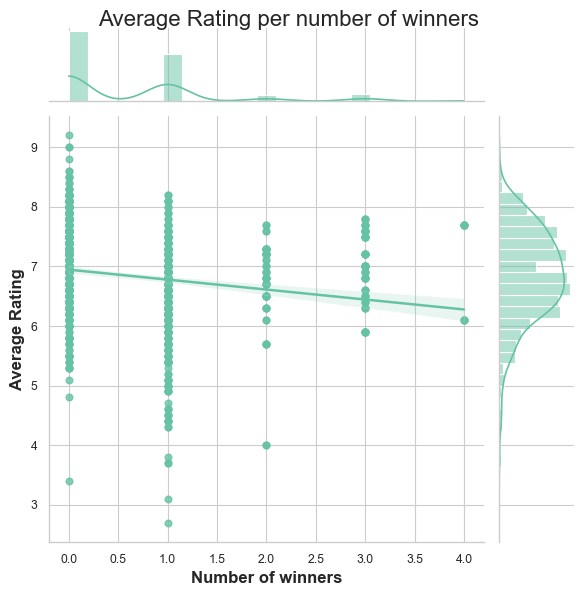

In [77]:
#plot the joint plot of the average rating and the number of winners
g = sns.jointplot(x=movie_metadata_winner_df['winning_actors'], 
                  y=movie_metadata_winner_df['averageRating'],
                  kind='reg',
                  height=6)

# Set labels and title
g.set_axis_labels('Number of winners', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per number of winners', fontsize=16)
g.fig.subplots_adjust(top=0.95)
plt.show()

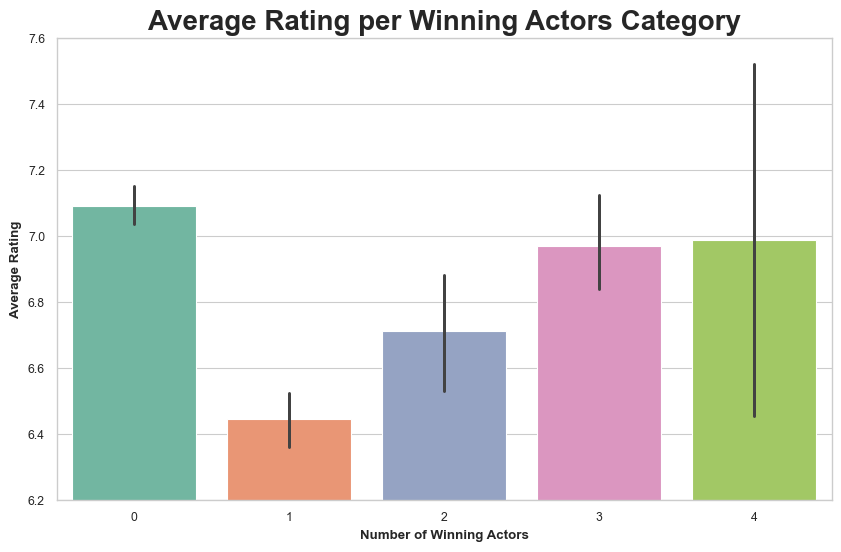

In [78]:
# plot the average rating per winning actors category
plt.figure(figsize=(10, 6))
sns.barplot(x='winning_actors', 
            y='averageRating', 
            data=movie_metadata_winner_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Winning Actors')
plt.ylabel('Average Rating')
plt.ylim(6.2, 7.6)
plt.title('Average Rating per Winning Actors Category')
plt.show()

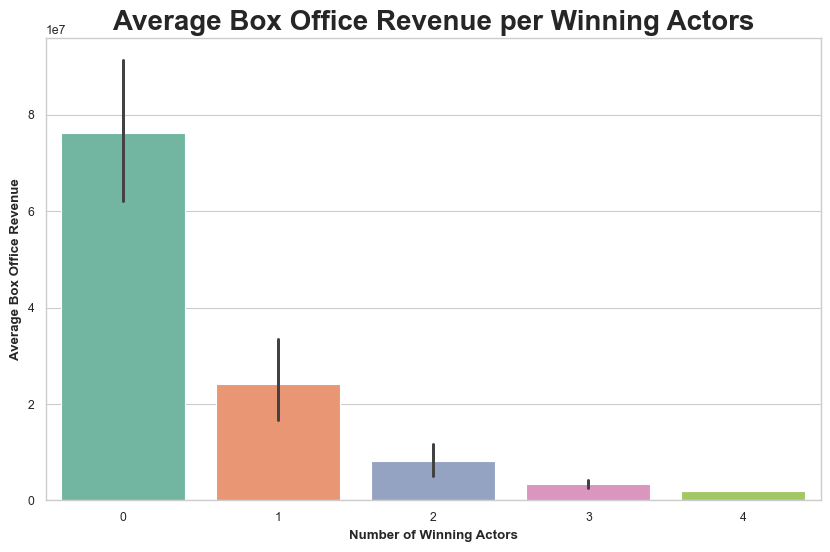

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(x='winning_actors', 
            y='movie_box_office_revenue', 
            data=movie_metadata_winner_df, 
            errorbar=('ci', 95))

plt.xlabel('Number of Winning Actors')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Winning Actors')
plt.show()

In [80]:
#perform an ols on the number of winners of each movie
reg = smf.ols('averageRating ~ winning_actors', 
              data=movie_metadata_winner_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     36.90
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.69e-09
Time:                        07:45:51   Log-Likelihood:                -1358.9
No. Observations:                1136   AIC:                             2722.
Df Residuals:                    1134   BIC:                             2732.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.9451      0.030    233.

## **9. Evaluate the effect of ethnicity on the IMDb rating**

### **Number of actors per movie**

In [81]:
character_metadata_ethnicity_df = character_metadata_df.copy()

In [82]:
number_of_actor_per_movie_df = character_metadata_ethnicity_df.groupby('wiki_movie_id')['actor_name'].apply(lambda x : x.count())
number_of_actor_per_movie_df.name = 'number_of_actor_per_movie'

In [83]:
movie_metadata_rating_ethnicity_df = pd.merge(movie_metadata_rating_df, number_of_actor_per_movie_df, on='wiki_movie_id', how='left')

In [84]:
movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'] = movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'].fillna(0)
movie_metadata_rating_ethnicity_df = movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'] != 0]

In [85]:
movie_metadata_rating_ethnicity_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie
27806,3624365,/m/09qnl9,Tsotsi,2005-12-23,9879971.0,94.0,"{""/m/0nl8g"": ""Xhosa Language"", ""/m/0x82"": ""Afr...","{""/m/0hzlz"": ""South Africa"", ""/m/07ssc"": ""Unit...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2005.0,tt0468565,7.2,29113,movie,14.0
3950,23691006,/m/06zqn06,Young Bill Hickok,1940-10-21,NaN,64.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",1940.0,tt0033286,5.7,262,movie,8.0
18764,8592074,/m/02794_3,The Yacoubian Building,2006-06-21,NaN,165.0,"{""/m/064_8sq"": ""French Language"", ""/m/0jzc"": ""...","{""/m/02k54"": ""Egypt""}","{""/m/0hn10"": ""LGBT"", ""/m/01t_vv"": ""Comedy-dram...",2006.0,tt0425321,7.5,7073,movie,13.0
34391,3782305,/m/09_q5s,The Turning Point,1952-11-15,NaN,85.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1952.0,tt0045267,6.8,1697,movie,7.0
382,17807776,/m/047b7yb,The Magic Hour,2008-06-07,NaN,136.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/01z4y"": ...",2008.0,tt1077089,7.1,1711,movie,8.0


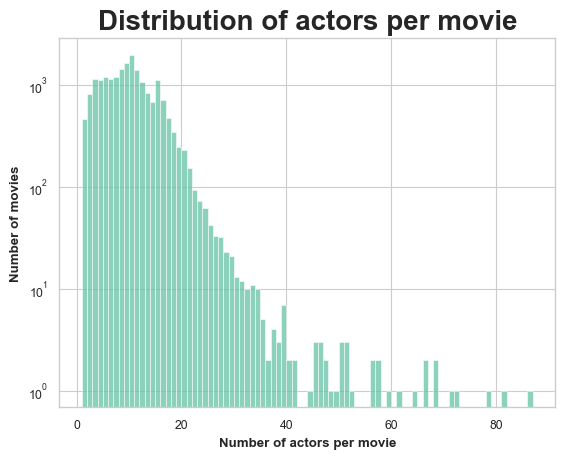

In [86]:
#plot the distribution of actors per movie
sns.histplot(movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"], 
             stat="count", 
             log_scale=(False, True), 
             kde=False, 
             binwidth=1)
plt.xlabel("Number of actors per movie")
plt.ylabel("Number of movies")
plt.title("Distribution of actors per movie")
plt.show()

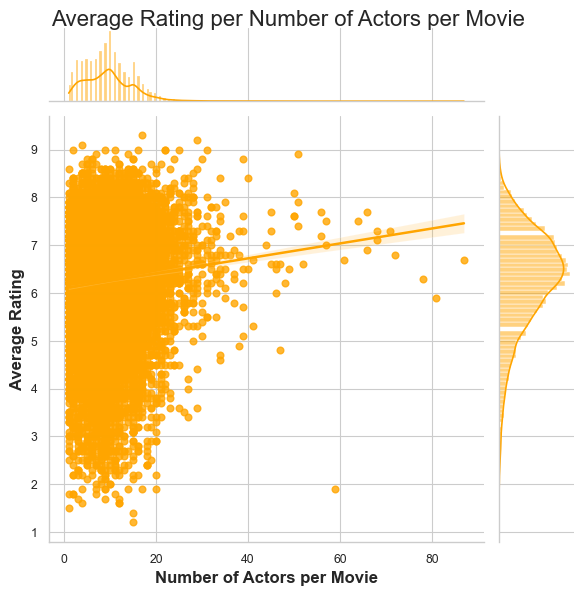

In [87]:
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['number_of_actor_per_movie'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg', 
                  height=6,
                  ci=95,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Number of Actors per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per Number of Actors per Movie', fontsize=16)
plt.show()

In [88]:
#perform an ols regression for the number of actors per movie
mod = smf.ols(formula='averageRating ~ number_of_actor_per_movie ',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     135.3
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.62e-31
Time:                        07:45:57   Log-Likelihood:                -29561.
No. Observations:               19841   AIC:                         5.913e+04
Df Residuals:                   19839   BIC:                         5.914e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

coef 0.012 is very small

In [89]:
stats.spearmanr(movie_metadata_rating_ethnicity_df["averageRating"], movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"])

SignificanceResult(statistic=0.07425782699219718, pvalue=1.1419316720399949e-25)

The null hypothesis of a Spearman correlation coefficient test is that there is no monotonic relationship between the two variables here our p < 0.05 this suggest to reject the HO and thus that our weak correlation coefficiant is significant.

à dev

lets dig into that

maybe consider to remove some movie with less than x actor

### **Ethnicity Score**

In [90]:
number_of_ethnicity_per_movie_df = \
    character_metadata_ethnicity_df.groupby('wiki_movie_id')['actor_ethnicity'].apply(lambda x : x.nunique())
number_of_ethnicity_per_movie_df.name = 'number_of_ethnicity_per_movie'

In [91]:
movie_metadata_rating_ethnicity_df = pd.merge(movie_metadata_rating_ethnicity_df, 
                                              number_of_ethnicity_per_movie_df, 
                                              on='wiki_movie_id', 
                                              how='left')

In [92]:
movie_metadata_rating_ethnicity_df = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'] != 0]

In [93]:
movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'].mean()

2.7032150033489617

In [94]:
movie_metadata_rating_ethnicity_df.shape

(14930, 16)

In [95]:
movie_metadata_rating_ethnicity_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie,number_of_ethnicity_per_movie
13620,3683823,/m/09v824,The World of Henry Orient,1964,NaN,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1964.0,tt0058756,6.6,3755,movie,9.0,2
13492,10556722,/m/02qhqz4,Astro Boy,2009-10-05,44093014.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",2009.0,tt0375568,6.2,39070,movie,19.0,9
4028,2400444,/m/079ggf,Six Pack,1982,NaN,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/01t_vv"": ""Comed...",1982.0,tt0084690,5.9,3246,movie,12.0,1
10939,4566486,/m/0c96qj,Hell Drivers,1957,NaN,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1957.0,tt0051713,7.2,3910,movie,6.0,3
14875,4762648,/m/0cl__c,University of Laughs,2004-10-25,NaN,121.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies""}",2004.0,tt0436886,7.4,1067,movie,2.0,1


In [96]:
movie_metadata_rating_ethnicity_df = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'] != 0]
print("Size of movie_metadata_rating_ethnicity_df:", movie_metadata_rating_ethnicity_df.shape)

Size of movie_metadata_rating_ethnicity_df: (14930, 16)


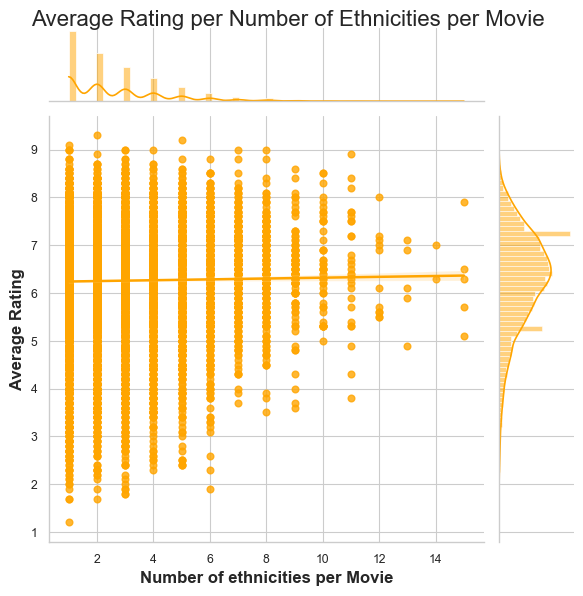

In [97]:
#plot the number of ethnicity per movie
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg',
                  height=6,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Number of ethnicities per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per Number of Ethnicities per Movie', fontsize=16)
plt.show()

In [98]:
#perform an ols regression for the number of ethnicity per movie
mod = smf.ols(formula='averageRating ~ number_of_ethnicity_per_movie',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.676
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0552
Time:                        07:46:03   Log-Likelihood:                -22083.
No. Observations:               14930   AIC:                         4.417e+04
Df Residuals:                   14928   BIC:                         4.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [99]:
stats.spearmanr(movie_metadata_rating_ethnicity_df['averageRating'], 
                movie_metadata_rating_ethnicity_df['number_of_ethnicity_per_movie'])

SignificanceResult(statistic=-0.017991115369107483, pvalue=0.027927800480499816)

In [100]:
movie_metadata_rating_ethnicity_df["ethnicity_score"] = \
    movie_metadata_rating_ethnicity_df["number_of_ethnicity_per_movie"] / movie_metadata_rating_ethnicity_df["number_of_actor_per_movie"]

movie_metadata_rating_ethnicity_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,number_of_actor_per_movie,number_of_ethnicity_per_movie,ethnicity_score
16362,61514,/m/0gnp3,The Story of Louis Pasteur,1936,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/01g6gs"": ""Black-...",1936.0,tt0028313,7.3,3039,movie,7.0,1,0.142857
12851,99545,/m/0pdp8,This Is Spinal Tap,1984-03-02,4736202.0,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/0l4h_"": ""Mockumenta...",1984.0,tt0088258,7.9,144703,movie,22.0,3,0.136364
9024,9170541,/m/027_1gl,Thoroughbreds Don't Cry,1937-12-03,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",1937.0,tt0029664,6.3,643,movie,5.0,2,0.400000
14603,5458357,/m/0dmsvv,PTU,2003,NaN,85.0,"{""/m/012w70"": ""Cantonese""}","{""/m/03h64"": ""Hong Kong"", ""/m/0d05w3"": ""China""}","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3l_y"": ""Actio...",2003.0,tt0250638,7.0,5034,movie,3.0,2,0.666667
18925,2361036,/m/076gv5,Conquest,1937,2141000.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/07s9rl0"": ""...",1937.0,tt0028739,6.5,1645,movie,4.0,1,0.250000


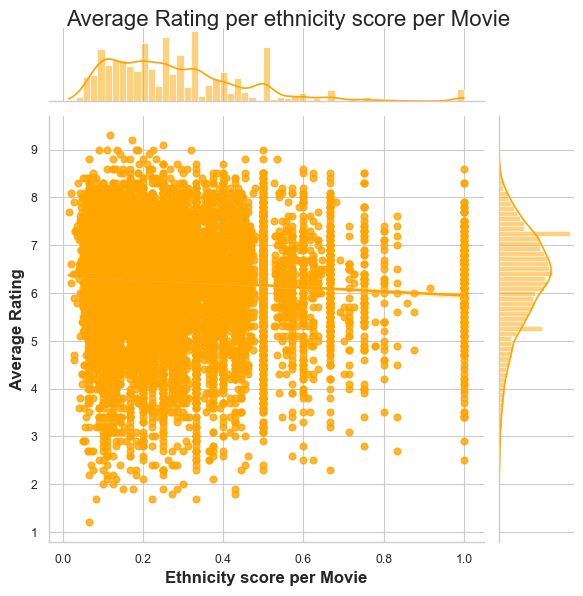

In [101]:
g = sns.jointplot(x=movie_metadata_rating_ethnicity_df['ethnicity_score'], 
                  y=movie_metadata_rating_ethnicity_df['averageRating'], 
                  kind='reg', 
                  height=6,
                  color='orange')

g.fig.subplots_adjust(top=0.95)
g.set_axis_labels('Ethnicity score per Movie', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per ethnicity score per Movie', fontsize=16)
plt.show()

In [102]:
#perform an ols regression for ethnicity score per movie
mod = smf.ols(formula='averageRating ~ ethnicity_score',
              data=movie_metadata_rating_ethnicity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     73.26
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.25e-17
Time:                        07:46:07   Log-Likelihood:                -22048.
No. Observations:               14930   AIC:                         4.410e+04
Df Residuals:                   14928   BIC:                         4.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.3760      0.017    3

In [103]:
stats.spearmanr(movie_metadata_rating_ethnicity_df["averageRating"], 
                movie_metadata_rating_ethnicity_df["ethnicity_score"])

SignificanceResult(statistic=-0.09065463172993904, pvalue=1.2703496670958593e-28)

In [104]:
ethnicity_score_above_05 = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df["ethnicity_score"] >= 0.5]["averageRating"]
ethnicity_score_under_05 = \
    movie_metadata_rating_ethnicity_df[movie_metadata_rating_ethnicity_df["ethnicity_score"] < 0.5]["averageRating"]

In [105]:
stats.ttest_ind(ethnicity_score_above_05, ethnicity_score_under_05)

TtestResult(statistic=-4.955530953471589, pvalue=7.292341987219383e-07, df=14928.0)

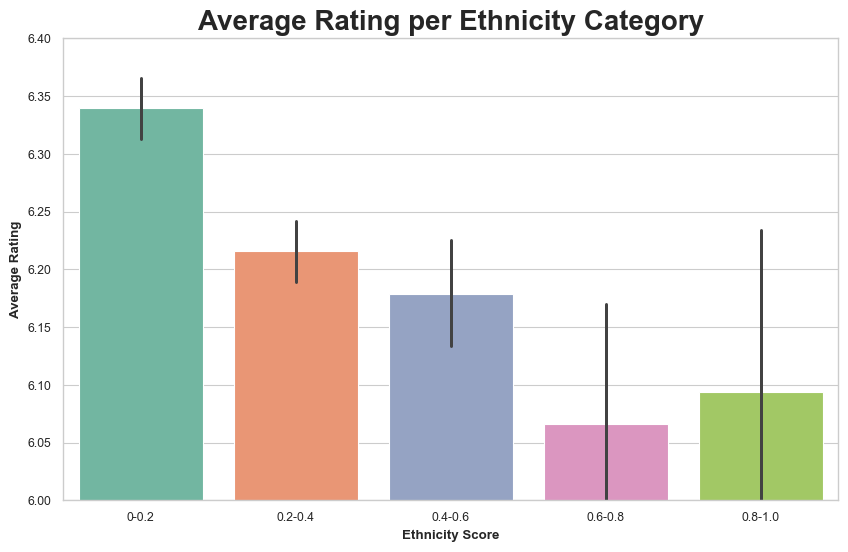

In [106]:
# Define the categories
categories = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# Categorize the ethnicity scores
movie_metadata_rating_ethnicity_df['ethnicity_category'] = pd.cut(movie_metadata_rating_ethnicity_df['ethnicity_score'], 
                                                                 bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                                                                 labels=categories)

# Plot the average rating per ethnicity category
plt.figure(figsize=(10, 6))
sns.barplot(x='ethnicity_category', 
            y='averageRating', 
            data=movie_metadata_rating_ethnicity_df, 
            errorbar=('ci', 95))

plt.xlabel('Ethnicity Score')
plt.ylabel('Average Rating')
plt.ylim(6, 6.4)
plt.title('Average Rating per Ethnicity Category')
plt.show()

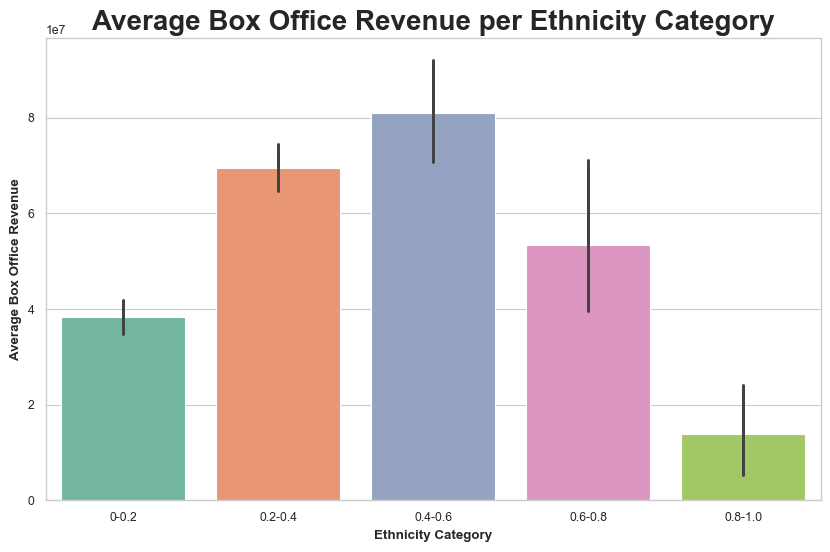

In [107]:
# Plot the average box office revenue per ethnicity category
plt.figure(figsize=(10, 6))
sns.barplot(x='ethnicity_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_rating_ethnicity_df, 
            errorbar=('ci', 95))

plt.xlabel('Ethnicity Category')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Ethnicity Category')
plt.show()


#### **Ethnicity uniform distribution analysis**

In [108]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_df = \
    character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)

We define the `ethnicities_names_df` dataframe, 

In [109]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
ethnicities_name_filename = 'data/RESULTS/ethnicities_name.csv'

if os.path.exists(ethnicities_name_filename):
    ethnicities_name_df = pd.read_csv(ethnicities_name_filename)
else:
    ethnicity_queried_values = [get_wikidata_id(value) for value in actor_ethnicity_df]
    ethnicities_name_df = \
        pd.DataFrame({'ethnicity_id': actor_ethnicity_df,
                      'ethnicity_name': ethnicity_queried_values})
    # save to csv
    ethnicities_name_df.to_csv(ethnicities_name_filename, index=False)

In [110]:
# merge character_metadata_df with df on actor_ethnicity and ethnicity_name
character_metadata_df = pd.merge(character_metadata_df, ethnicities_name_df, 
                                 left_on='actor_ethnicity', 
                                 right_on='ethnicity_id', 
                                 how='left')

character_metadata_df.drop(columns=["ethnicity_id"], inplace=True)
character_metadata_df.rename(columns={'actor_ethnicity': 'actor_ethnicity_id', 
                                      'ethnicity_name':'actor_ethnicity'}, 
                                      inplace=True)
character_metadata_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
149000,570258,/m/02r3w_,1965-12-19,Chairman of Earth Committee,1898-01-30,M,NaN,NaN,Takamaru Sasaki,NaN,/m/0cw0dpl,/m/0hsxrqd,/m/0bvyd3n,1965.0,NaN
53750,29552360,/m/0ds2xr4,2011-10-07,NaN,NaN,M,NaN,NaN,Shankar Debnath,NaN,/m/0hntzcx,NaN,/m/0hntzcv,2011.0,NaN
52795,22683298,/m/05zz8kj,1999-09-24,Rahul Kumar,1963-12-21,M,1.730,/m/0dryh9k,Govinda,35.0,/m/0h6yp_z,/m/0kcqrp7,/m/05_zc7,1999.0,Indian person
20188,29381759,/m/0cp17y7,2010-09-07,Franco,NaN,NaN,NaN,NaN,Juan Viadas,NaN,/m/0cpnmzy,/m/0h5t201,/m/0cpnm_0,2010.0,NaN
36876,10671108,/m/02qlth5,2005-11-09,Bryant,1967-11-05,F,1.588,/m/0912ll,Judy Reyes,38.0,/m/045_6c7,/m/0h5tkjb,/m/07jjmz,2005.0,Dominican Americans


In [111]:
# drop na values from the actor_ethnicity column
character_metadata_df = character_metadata_df.dropna(subset=['actor_ethnicity'])

#only keep wiki_movie_id and actor_ethnicity columns
character_metadata_encoded_df = character_metadata_df[['wiki_movie_id', 'actor_ethnicity']]

# Perform one-hot encoding on the actor_ethnicity column
character_metadata_encoded_df = pd.get_dummies(character_metadata_encoded_df, columns=['actor_ethnicity'])

character_metadata_encoded_df.sample(5)

,wiki_movie_id,actor_ethnicity_Acadians,actor_ethnicity_Afghans in India,actor_ethnicity_African Americans,actor_ethnicity_African people,actor_ethnicity_Afro Trinidadians and Tobagonians,actor_ethnicity_Afro-Asians,actor_ethnicity_Afro-Cuban,actor_ethnicity_Afro-Guyanese,actor_ethnicity_Agrawal,...,actor_ethnicity_Xhosa people,actor_ethnicity_Yoruba people,actor_ethnicity_Yugoslavs,actor_ethnicity_culture of Palestine,actor_ethnicity_history of the Jews in the African diaspora,actor_ethnicity_multiracial people,actor_ethnicity_names of the Greeks,actor_ethnicity_peoples of the Caucasus,actor_ethnicity_rajput,actor_ethnicity_white people
25853,6003967,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
51249,2586953,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
53078,11818376,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
182119,3681345,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
149830,5240530,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [112]:
#compute the number of actors for each ethnicity for each movie
grouped_df = character_metadata_encoded_df.groupby('wiki_movie_id').sum()
grouped_df.sample(5)

,actor_ethnicity_Acadians,actor_ethnicity_Afghans in India,actor_ethnicity_African Americans,actor_ethnicity_African people,actor_ethnicity_Afro Trinidadians and Tobagonians,actor_ethnicity_Afro-Asians,actor_ethnicity_Afro-Cuban,actor_ethnicity_Afro-Guyanese,actor_ethnicity_Agrawal,actor_ethnicity_Akan people,...,actor_ethnicity_Xhosa people,actor_ethnicity_Yoruba people,actor_ethnicity_Yugoslavs,actor_ethnicity_culture of Palestine,actor_ethnicity_history of the Jews in the African diaspora,actor_ethnicity_multiracial people,actor_ethnicity_names of the Greeks,actor_ethnicity_peoples of the Caucasus,actor_ethnicity_rajput,actor_ethnicity_white people
wiki_movie_id,,,,,,,,,,,,,,,,,,,,,
5501399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2772250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102966,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1518813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
#apply the shannon entropy function to the grouped_df
grouped_df_sdi = grouped_df.apply(lambda x: SDI(x), axis=1)

#merge the grouped_df_sdi with the movie_metadata_rating_df
movie_metadata_rating_df = pd.merge(movie_metadata_rating_df, 
                                    grouped_df_sdi.rename('SDI'), 
                                    on='wiki_movie_id', 
                                    how='left')

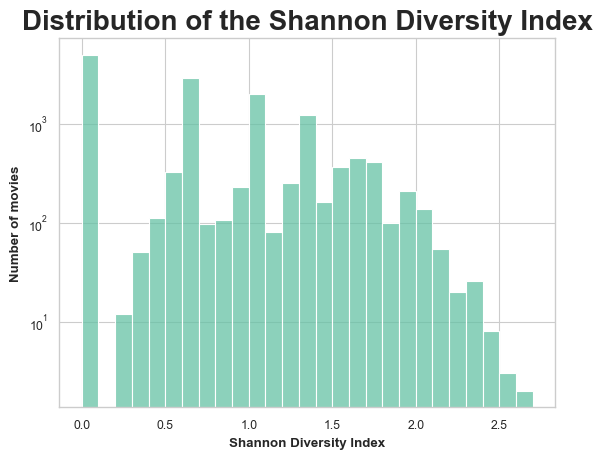

In [114]:
#plot the distribution of the SDI
sns.histplot(grouped_df_sdi, 
             stat="count", 
             log_scale=(False, True), 
             kde=False, 
             binwidth=0.1)
plt.xlabel("Shannon Diversity Index")
plt.ylabel("Number of movies")
plt.title("Distribution of the Shannon Diversity Index")
plt.show()

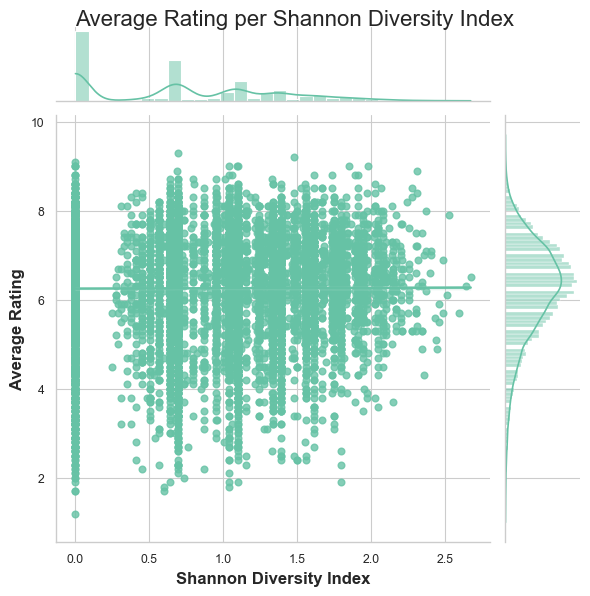

In [115]:
# Create a joint plot with on x-axis
g = sns.jointplot(x='SDI', 
                  y='averageRating', 
                  data=movie_metadata_rating_df, 
                  kind='reg')

# Set the axis labels and title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Average Rating per Shannon Diversity Index', fontsize=16)
g.set_axis_labels('Shannon Diversity Index', 'Average Rating', fontsize=12)
plt.show()

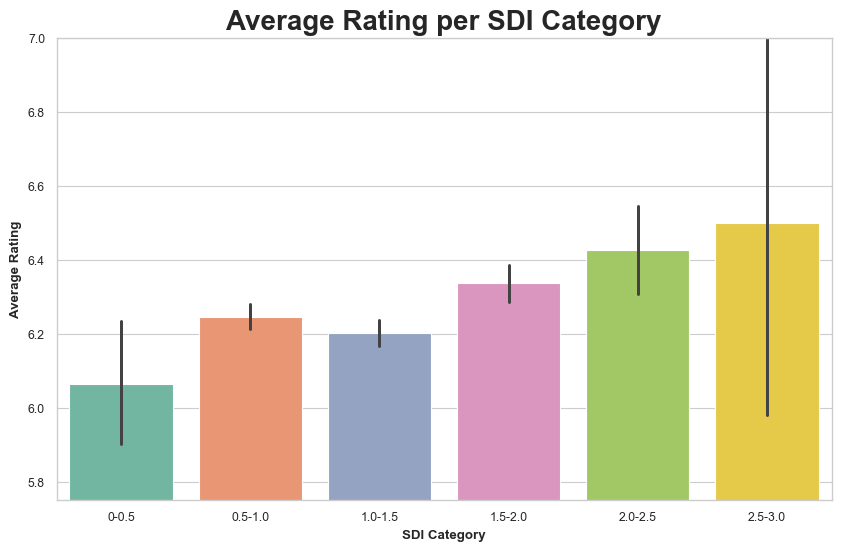

In [116]:
# Define the categories
categories = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0']

movie_metadata_revenue_sdi_df = movie_metadata_rating_df[['wiki_movie_id', 
                                                          'averageRating', 
                                                          'movie_box_office_revenue', 
                                                          'SDI']]

# Categorize the SDI values
movie_metadata_revenue_sdi_df['SDI_category'] = pd.cut(movie_metadata_revenue_sdi_df['SDI'], 
                                                  bins=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 
                                                  labels=categories)

# Plot the average rating per SDI category
plt.figure(figsize=(10, 6))
sns.barplot(x='SDI_category', 
            y='averageRating', 
            data=movie_metadata_revenue_sdi_df, 
            errorbar=('ci', 95))

plt.xlabel('SDI Category')
plt.ylim(5.75, 7)
plt.ylabel('Average Rating')
plt.title('Average Rating per SDI Category')
plt.show()

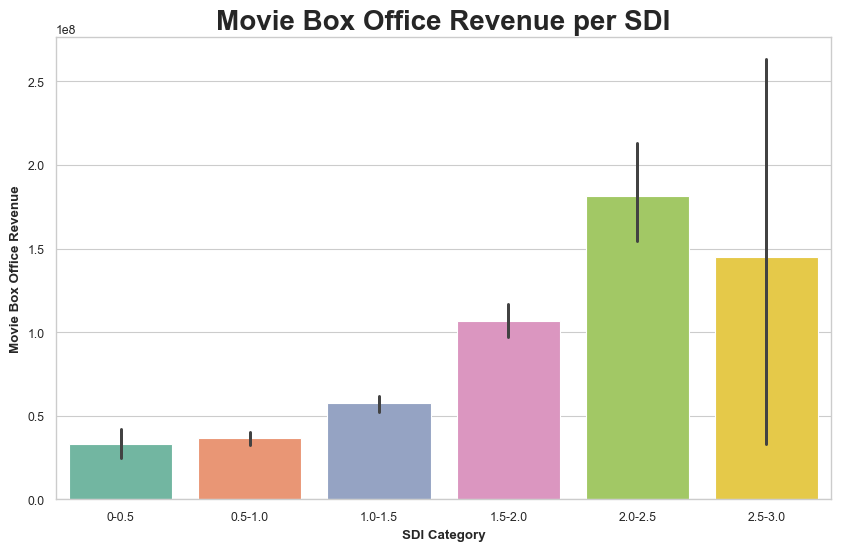

In [117]:
# Plot the average rating per SDI category
plt.figure(figsize=(10, 6))
sns.barplot(x='SDI_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_revenue_sdi_df, 
            errorbar=('ci', 95))

plt.xlabel('SDI Category')
plt.ylabel('Movie Box Office Revenue')
plt.title('Movie Box Office Revenue per SDI')
plt.show()

In [118]:
movie_ethnicity_score_df = movie_metadata_rating_df[['wiki_movie_id', 'SDI', 'averageRating']]
movie_ethnicity_score_df.dropna(inplace=True)
movie_ethnicity_score_df.head(10)

,wiki_movie_id,SDI,averageRating
0,975900,0.636514,4.9
6,171005,0.950271,7.5
7,77856,0.636514,7.8
10,21926710,0.000000,6.1
13,156558,0.000000,6.4
15,9633533,0.867563,7.9
20,26067101,0.000000,6.4
22,25960460,1.332179,5.6
24,12008535,0.693147,6.7
25,4951456,1.098612,5.5


In [119]:
# split the dataframe into two based on SDI value
movie_ethnicity_score_df_under_half = movie_ethnicity_score_df[movie_ethnicity_score_df['SDI'] < 1.75]
movie_ethnicity_score_df_over_half = movie_ethnicity_score_df[movie_ethnicity_score_df['SDI'] >= 1.75]

t_statistic, p_value = stats.ttest_ind(movie_ethnicity_score_df_over_half['averageRating'], 
                                       movie_ethnicity_score_df_under_half['averageRating'])

print("p-value:", p_value)

p-value: 0.0008825989100480101


In [120]:
#perform an ols regression for the Shannon Diversity Index per movie
mod = smf.ols(formula='averageRating ~ SDI',
              data=movie_ethnicity_score_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3580
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.550
Time:                        07:46:18   Log-Likelihood:                -21874.
No. Observations:               14778   AIC:                         4.375e+04
Df Residuals:                   14776   BIC:                         4.377e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2493      0.013    470.205      0.0

## **10. Evaluate the effect of the gender proportion of a movie on the IMDb rating**

In [121]:
movie_metadata_parity_df = \
    movie_metadata_rating_df[['wiki_movie_id', 'averageRating']]

In [122]:
character_gender_df = character_metadata_df[['wiki_movie_id', 'actor_gender']]
character_gender_df.dropna(inplace=True)

print("Size of character_gender_df:", character_gender_df.size)
character_gender_df.sample(5)

Size of character_gender_df: 101670


,wiki_movie_id,actor_gender
19228,4669663,F
176095,4584210,M
160942,13901,F
165816,1373219,M
11436,10418730,M


In [123]:
# Count the number of male and female actors per movie
gender_counts_df = character_gender_df.groupby('wiki_movie_id')['actor_gender'].value_counts().unstack()

# Replace NaN with 0
gender_counts_df = gender_counts_df.fillna(0)

# Compute the parity in actor gender
gender_parity_df = gender_counts_df['F'] / gender_counts_df.sum(axis=1) * 100

movie_metadata_parity_df = pd.merge(movie_metadata_rating_df, 
                                    gender_parity_df.rename('parity'), 
                                    left_on='wiki_movie_id', 
                                    right_index=True, 
                                    how='inner')

print("Size of movie_metadata_rating_df:", movie_metadata_rating_df.shape)
movie_metadata_parity_df.sample(5)

Size of movie_metadata_rating_df: (39963, 15)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,SDI,parity
20918,2475962,/m/07gns9,Gray Lady Down,1978-04,NaN,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",1978.0,tt0077629,6.2,3460,movie,1.560710,0.0
4053,12030606,/m/02vmhbr,El Dorado,1988-04-20,NaN,149.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0f8l9c"": ""France"", ""/m/06mkj"": ""Spain"", ""...","{""/m/07s9rl0"": ""Drama""}",1988.0,tt0095053,6.3,643,movie,0.000000,100.0
2348,13915018,/m/03cn3by,Ponthan Mada,1994,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",1994.0,tt0248317,8.0,1005,movie,0.636514,0.0
34675,2423947,/m/07c29b,Still Crazy,1998-10-30,524864.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0gf28"": ""Parody"", ""/m/04228s"": ""Road movi...",1998.0,tt0149151,7.0,8540,movie,1.039721,0.0
19443,35570671,/m/0jkwd95,Lucignolo,1999-03-05,NaN,90.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/05p553"": ""Comedy film""}",1999.0,tt0179952,5.3,485,movie,0.000000,0.0


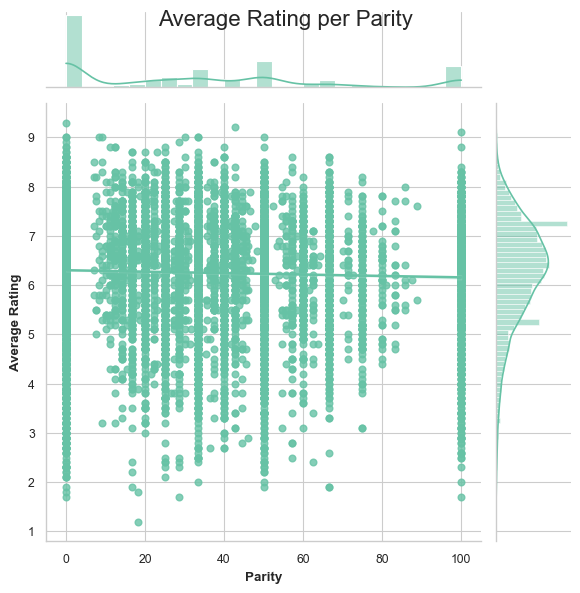

In [124]:
#plot the joint plot of parity and average rating
g = sns.jointplot(x='parity', 
                  y='averageRating', 
                  data=movie_metadata_parity_df,
                  kind='reg')

#set the axis labels and title
g.set_axis_labels('Parity', 'Average Rating')
g.fig.suptitle('Average Rating per Parity', fontsize=16)
plt.show()

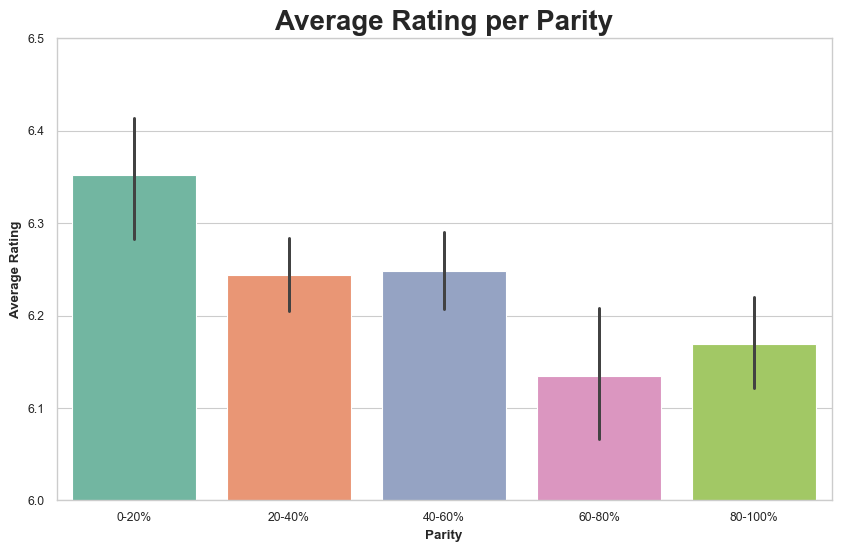

In [125]:
# Define the categories
categories = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

movie_metadata_revenue_parity_df = movie_metadata_parity_df[['wiki_movie_id', 
                                                          'averageRating', 
                                                          'movie_box_office_revenue', 
                                                          'parity']]

# Categorize the parity values
movie_metadata_revenue_parity_df['parity_category'] = pd.cut(movie_metadata_revenue_parity_df['parity'], 
                                                     bins=[0, 20, 40, 60, 80, 100], 
                                                     labels=categories)

# Plot the average rating per parity category
plt.figure(figsize=(10, 6))
sns.barplot(x='parity_category', 
            y='averageRating', 
            data=movie_metadata_revenue_parity_df, 
            errorbar=('ci', 95))

plt.xlabel('Parity')
plt.ylabel('Average Rating')
plt.ylim(6, 6.5)
plt.title('Average Rating per Parity')
plt.show()

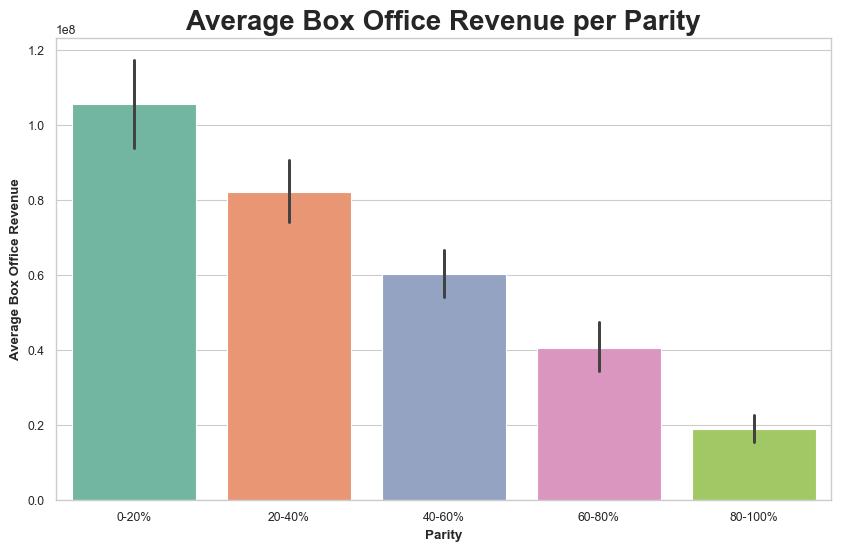

In [126]:
# Categorize the parity values
movie_metadata_revenue_parity_df['parity_category'] = pd.cut(movie_metadata_revenue_parity_df['parity'], 
                                                     bins=[0, 20, 40, 60, 80, 100], 
                                                     labels=categories)

# Plot the average box office revenue per parity category
plt.figure(figsize=(10, 6))
sns.barplot(x='parity_category', 
            y='movie_box_office_revenue', 
            data=movie_metadata_revenue_parity_df, 
            errorbar=('ci', 95))

plt.xlabel('Parity')
plt.ylabel('Average Box Office Revenue')
plt.title('Average Box Office Revenue per Parity')
plt.show()

In [127]:
# split the dataframe into two based on parity value
movie_parity_score_df_under_half = \
    movie_metadata_revenue_parity_df[movie_metadata_revenue_parity_df['parity'] < 50]
movie_parity_score_df_over_half = \
    movie_metadata_revenue_parity_df[movie_metadata_revenue_parity_df['parity'] >= 50]

# perform t-test for parity
t_statistic_parity, p_value_parity = stats.ttest_ind(movie_parity_score_df_over_half['averageRating'], 
                                                     movie_parity_score_df_under_half['averageRating'])

print("p-value for parity:", p_value_parity)

p-value for parity: 3.7678560274879865e-06


In [128]:
#perform an ols regression for parity
mod = smf.ols(formula='averageRating ~ parity',
              data=movie_metadata_revenue_parity_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.43
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           5.90e-08
Time:                        07:46:23   Log-Likelihood:                -21844.
No. Observations:               14769   AIC:                         4.369e+04
Df Residuals:                   14767   BIC:                         4.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3023      0.012    514.571      0.0

## **11. Evaluate the effect of movie genre on the IMDb rating**

We define the `movie_genres_df` dataframe, which contains the genres of movies. We construct this dataframe by reading the `movie_genres` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of genre_id and genre_name. We then extract the genre_name and add it to the a new column called `movie_genres`.

In [129]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_rating_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_rating_df['movie_genres'].apply(transform_genres_string)
genres_df = movie_genres_df['movie_genres']
genres_df.sample(5)

38620                    {'/m/0771_': 'Spaghetti Western'}
34010    {'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...
33446                                                   {}
34987    {'/m/03q4nz': 'World cinema', '/m/0jtdp': 'Doc...
27587    {'/m/0hj3m_x': 'Crime Comedy', '/m/03q4nz': 'W...
Name: movie_genres, dtype: object

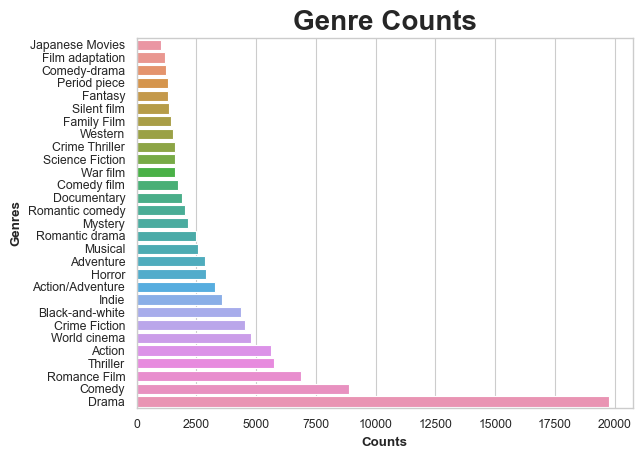

Mean absolute error of linear regression on genres: 0.7563669684996784


In [130]:
THRESHOLD = 100
genres_filtered_df = filter_genres(genres_df, 1000, True)
dummy_variables_df = get_genre_dummies(genres_filtered_df)
genres_df = dummy_variables_df.merge(movie_metadata_rating_df['averageRating'], 
                                     left_index=True,
                                     right_index= True,
                                     how='left').copy()

X_column_names = [col for col in genres_df.columns if col != 'averageRating']
y_column_names = ['averageRating']
model_genres, mae = linear_regression(X_column_names, y_column_names, genres_df)
print("Mean absolute error of linear regression on genres:", mae)

### **Predicting Movie rating soleley on genre information**

Running linear regression with a 0.8/0.2 or 0.85/0.15 train/test split, we get a mean absolute error of 0.72 for a threshold of 750 (meaning genres with less than 750 representatives aaren't represented), we coul use a stricter or more loosse threshold, the result doesn't change all that much. It would be interresting to if the time when the film went out plays a role in the films' sucess.

In [131]:
show_model(model_genres)

How certain can we be of our guess, when predicting on genres? Data shows, that it doesn't purely depend on the genre in question (cf model results and p-values of different coefficients, represented on this graph) but also on the year in question. Running linear regression on data grouped by yars, we can see a steady risse in error, indicating more unceartainty present in recent years. A logical observation would be to account for more recent films in our data in addition to older films haven gone through the proof of time.

or someething like: as we can see, the uncertainty grows with the years. First of all, we have to remember that our data has more releses closer to the present. Logically, the films that "stood the test of time" and found their way into the dataset are more likely to be of better quality, since they have not been forgotten, while the modern creations find their way into lists without any paticular trrouble.

### **Looking at errors when training and testing on the same year**

In [132]:
years = list(range(1930, 2020, 5))
errors = []
for year in years:
    df = movie_metadata_rating_df.copy()
    filt_metadata_df = df[movie_metadata_rating_df['movie_release_year'] < year]
    filt_metadata_df = filt_metadata_df[filt_metadata_df['movie_release_year'] >= year-5]
    errors.append(full_genre_process(filt_metadata_df, 100)[1])

fig = go.Figure(data=go.Scatter(x=years, y=errors, mode='lines+markers'))
fig.update_layout(title='Linear Regression Mean Absolute Error for a given 5 year period',
                  xaxis_title='Years',
                  yaxis_title='Mean Absolute Error')
fig.show()

In [133]:
# Plot 1: Average Rating per Year (Line Plot)
df = movie_metadata_rating_df[movie_metadata_rating_df['movie_release_year'] > 1920].copy()
df = df.groupby('movie_release_year')['averageRating'].mean().reset_index()

# Create a line trace for "Average Rating per Year"
line_trace = go.Scatter(
    x=df['movie_release_year'],
    y=df['averageRating'],
    mode='lines',
    name='Average Rating',
    line=dict(color='blue'),  # Customize line color
)

# Create a layout
layout = go.Layout(
    title='Average Rating per Year',
    xaxis=dict(title='Years'),
    yaxis=dict(title='Average Rating'),
)
fig1 = go.Figure(data=[line_trace], layout=layout)
fig1.update_xaxes(title_text='Years')
fig1.update_yaxes(title_text='Average Rating')

# Plot 2: Distribution of Top 1000 Movies by Year (Histogram)
df_top_1000 = movie_metadata_rating_df.sort_values(by='averageRating', ascending=False).head(1000)
fig2 = px.histogram(df_top_1000, x='movie_release_year', nbins=10, title='Distribution of Top 1000 Movies by Year')
fig2.update_xaxes(title_text='Years')
fig2.update_yaxes(title_text='Counts')

# Create a subplot with two plots vertically
fig = ps.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

# Update layout and titles
fig.update_layout(height=600, title_text="Average Ratings per year vs Top 1000 Movie Distribution Over Years")

# Show the plot
fig.show()

### **Where them good fims at?**

A as we can see, the avarrage ratting of films seems to go down throughouut years, yet if we analise the top 1000 movies, we see that they are more likeley to be found in the recent years. Considering that the evaluation of movie genres wasn't quite sufficient, why not try gain more information on their "vibe" by analising the plots. Such analysis can be conducted with the aid of NLP tools, it is however important to reflect on what sort of information we want to use.

Having observed the different prrertrained models and their caapabilaties (as much as the capabilaties of our hardware), it seemed that an interesting aproach would be utilizing the zero-shot-classification capabilaty of DeBERTa-v3-base-mnli-fever-anli, a pretrained and fine-tuned model we found on hugging face. Given a text and a list of labels as input, the model assigns probabilaties to each of the labels (together summing to 1). Thus, an interesting aprroach would be to create multiple lists with emelements from similar groups and running thee model on all the texts and lists, get orer informattion about the time period described in the plot, a particular way the plot was constructed, what sort of problem is the story constructed around etc.

Since this is a computation heavy process, it was decided to only run in on parrt of our dataset, nameley films coming out after 1980 and having more than 1000 votes. This still gave us 9900 samples to work with.

In [134]:
metadata_df = movie_metadata_rating_df.set_index('wiki_movie_id')
metadata_df = metadata_df[metadata_df['movie_release_year'] > 1980].copy()
metadata_df = metadata_df[metadata_df['numVotes'] > 1000].copy()

In [135]:
rating_labels = create_labels_df(threshold = 0.4, path_to_file = 'data/DeBERTa-v3/complete_De-BERTa_plots.csv')
rating_labels, labels = filter_labels(rating_labels,10,600)
print("Number of labels left after filtering:", len(labels))
print("Rating labels shape:", rating_labels.shape)

Number of labels left after filtering: 151
Rating labels shape: (8161,)


In [136]:
show_label_counts(rating_labels, 20)

In [137]:
labels_rattings_df = \
    pd.DataFrame(rating_labels).merge(metadata_df['averageRating'], 
                                      left_index=True, 
                                      right_index=True, 
                                      how='left').copy()

show_label_means(labels_rattings_df, 10)

Finaly, we perform a linear regression on the data

In [138]:
dummy_labels = get_label_dummies(rating_labels)
dummy_labels_rating = dummy_labels.merge(metadata_df['averageRating'], left_index=True, right_index=True, how='left').copy()
model, mal = linear_regression(dummy_labels.columns,['averageRating'], dummy_labels_rating)
print("Mean absolute loss when doing linear regreession:", mal)

Mean absolute loss when doing linear regreession: 0.8172447844553768


We then check how will the same samples would compare if we try to predict soleley on their genre data

In [139]:
df = metadata_df.copy()
df = df.loc[rating_labels.index]
genre_model , genre_mal = full_genre_process(df, 100)
print("Mean absolute loss when doing linear regreession on genre column:", genre_mal)

Mean absolute loss when doing linear regreession on genre column: 0.7247300034084617


In [140]:
show_model(model)

As we can see, the confidence intervals are larger than in the case of genres and the most influentual labels are those that correlate the modst with a specific genre, however this is more information we can work with and it seems to be menaingful in one way or another. Now, it would be interesting to combine thhe knowledge we have on genres and labels together in order to get a more specialised model.

In [141]:
df = metadata_df['movie_genres'].copy().apply(lambda x: transform_genres_string(x))
df = df.loc[rating_labels.index]
df = get_genre_dummies(df)
df = df.merge(dummy_labels_rating, left_index=True, right_index=True, how='left')
combined_model, combined_mae = linear_regression(df.columns[:-1],['averageRating'], df)
print("Mean absolute loss when doing linear regreession on genre combined with labels:", combined_mae)

Mean absolute loss when doing linear regreession on genre combined with labels: 0.7233611978738222


In [142]:
show_model(combined_model)

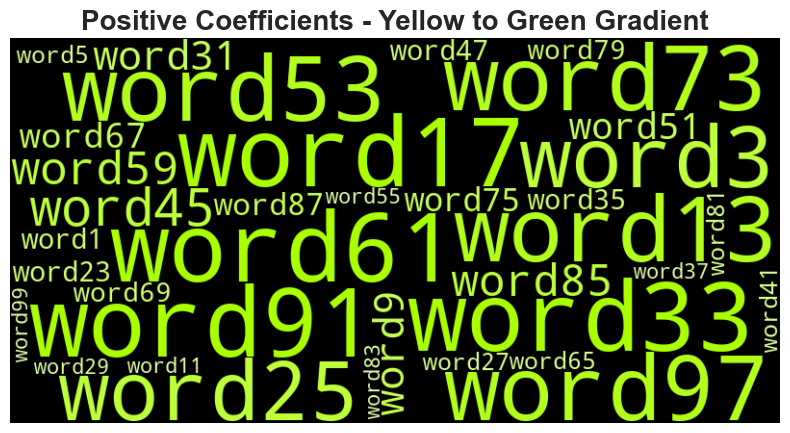

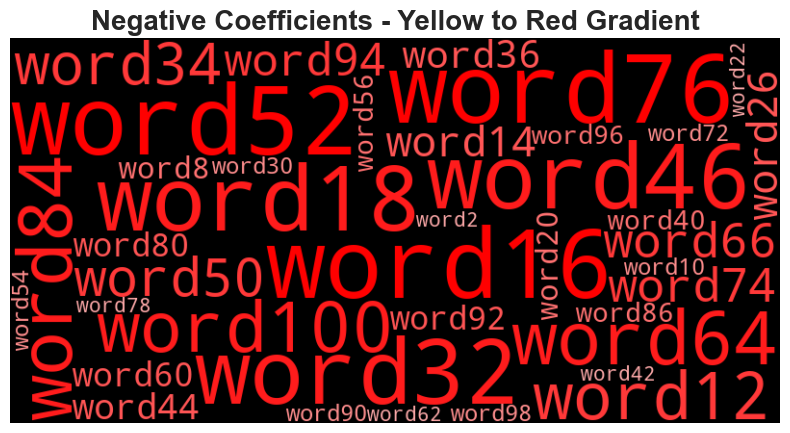

In [143]:
# Sample data
keywords = [
    'word1', 'word2', 'word3', 'word4', 'word5', 'word6', 'word7', 'word8', 'word9', 'word10',
    'word11', 'word12', 'word13', 'word14', 'word15', 'word16', 'word17', 'word18', 'word19', 'word20',
    'word21', 'word22', 'word23', 'word24', 'word25', 'word26', 'word27', 'word28', 'word29', 'word30',
    'word31', 'word32', 'word33', 'word34', 'word35', 'word36', 'word37', 'word38', 'word39', 'word40',
    'word41', 'word42', 'word43', 'word44', 'word45', 'word46', 'word47', 'word48', 'word49', 'word50',
    'word51', 'word52', 'word53', 'word54', 'word55', 'word56', 'word57', 'word58', 'word59', 'word60',
    'word61', 'word62', 'word63', 'word64', 'word65', 'word66', 'word67', 'word68', 'word69', 'word70',
    'word71', 'word72', 'word73', 'word74', 'word75', 'word76', 'word77', 'word78', 'word79', 'word80',
    'word81', 'word82', 'word83', 'word84', 'word85', 'word86', 'word87', 'word88', 'word89', 'word90',
    'word91', 'word92', 'word93', 'word94', 'word95', 'word96', 'word97', 'word98', 'word99', 'word100'
]

coefficients = [
    0.5, -0.3, 0.7, -0.2, 0.4, -0.1, 0.2, -0.5, 0.6, -0.4,
    0.3, -0.7, 0.8, -0.6, 0.1, -0.9, 0.9, -0.8, 0.0, -0.5,
    0.2, -0.3, 0.5, -0.1, 0.7, -0.6, 0.4, -0.2, 0.3, -0.4,
    0.6, -0.8, 0.9, -0.7, 0.5, -0.6, 0.3, -0.2, 0.1, -0.5,
    0.4, -0.3, 0.2, -0.6, 0.7, -0.8, 0.5, -0.1, 0.0, -0.7,
    0.6, -0.9, 0.8, -0.4, 0.3, -0.5, 0.1, -0.2, 0.7, -0.6,
    0.9, -0.3, 0.1, -0.8, 0.4, -0.7, 0.6, -0.2, 0.5, -0.1,
    0.0, -0.4, 0.8, -0.7, 0.6, -0.9, 0.2, -0.3, 0.5, -0.6,
    0.4, -0.1, 0.3, -0.8, 0.7, -0.5, 0.6, -0.2, 0.0, -0.4,
    0.9, -0.6, 0.2, -0.7, 0.1, -0.5, 0.8, -0.4, 0.3, -0.8
]

# Separate keywords into positive and negative based on coefficients
positive_word_freq = {keywords[i]: abs(coefficients[i]) for i in range(len(keywords)) if coefficients[i] > 0}
negative_word_freq = {keywords[i]: abs(coefficients[i]) for i in range(len(keywords)) if coefficients[i] < 0}

# Custom color functions for gradients
class ColorFuncWithGradient(object):
    def __init__(self, color_hue, word_freq):
        self.color_hue = color_hue
        self.word_freq = word_freq

    def __call__(self, word, font_size, position, orientation, random_state=None, **kwargs):
        # Normalize coefficient value to a scale of 0 to 1
        normalized_weight = self.word_freq[word] / max(self.word_freq.values())
        lightness = 100 - normalized_weight * 50  # Scale lightness
        lightness = max(0, min(lightness, 100))  # Ensure lightness is between 0 and 100
        return f"hsl({self.color_hue}, 100%, {lightness}%)"

# Function to create and display word cloud
def create_and_display_wordcloud(word_freq, color_hue, title):
    wordcloud = WordCloud(width=800, height=400, max_font_size=100, min_font_size=20)
    wordcloud.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=ColorFuncWithGradient(color_hue, word_freq)), interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Create and display word clouds with gradient colors
create_and_display_wordcloud(positive_word_freq, 80, "Positive Coefficients - Yellow to Green Gradient")
create_and_display_wordcloud(negative_word_freq, 0, "Negative Coefficients - Yellow to Red Gradient")